# Credit Classification Analysis

# Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler, PowerTransformer, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline as sklearnPipeline

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score, make_scorer, confusion_matrix
from sklearn.metrics import roc_curve as sklearn_roc_curve, auc, RocCurveDisplay
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_predict, cross_val_score, train_test_split, RandomizedSearchCV
from sklearn.feature_selection import SelectKBest, mutual_info_classif, f_classif

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier

# Functions

In [34]:
def check_nulls_dupes(df):
  print(f"The amount of Nulls: {df.isna().sum()}")
  print(f"The amount of Dupes {df.duplicated().sum()}")

def check_class_imbalance(target):
  
  unique, counts = np.unique(target, return_counts=True)
  
  plt.figure(figsize=(10, 7))
  plt.pie(counts, labels= unique, startangle=140, autopct="%1.1f%%")
  plt.title("Target Class Breakdown")
  plt.show()
  
  plt.figure(figsize=(10, 7))
  sns.countplot(x=target)
  plt.title("Target Class Breakdown")
  plt.ylabel("Frequency")
  plt.show()

def plot_distribution(df, dist_type):
  
  plt.figure(figsize=(16, 16))
  rows = len(df.columns)
  dims = (rows+ 4)//3
  
  for idx, col in enumerate(df.columns):
    plt.subplot(dims, 4, idx+1)
    sns.histplot(df[col], kde=True) if dist_type == "hist" else sns.boxplot(df[col])
    plt.title(f"Distirbution of {col}") if dist_type == "hist" else plt.title(f"Boxplot of {col}")
  plt.tight_layout()
  plt.show()

def aggregate_dataset(df,agg_col, col, function):
  
  plt.figure(figsize=(10,7))

  grouped_df = getattr(df.groupby(agg_col)[col],function)().reset_index(name=col)
  sns.barplot(data=grouped_df, x=agg_col, y=col)
  plt.title(f"Agg of {col}")
  plt.ylabel(col)
  plt.xticks(rotation =45)
  plt.tight_layout()
  plt.show()

def dist_plot(df, col):
  salary_skewness = df[col].skew()
  salary_kurtosis = df[col].kurtosis()

  plt.figure(figsize=(10, 6))
  sns.histplot(df[col], kde=True, color='blue')
  plt.title(f'Distribution of {col} with Skewness and Kurtosis')
  plt.xlabel(col)
  plt.ylabel('Frequency')

  plt.text(x=0.95, y=0.85, s=f"Skewness: {salary_skewness:.2f}", transform=plt.gca().transAxes, horizontalalignment='right')
  plt.text(x=0.95, y=0.80, s=f"Kurtosis: {salary_kurtosis:.2f}", transform=plt.gca().transAxes, horizontalalignment='right')

  plt.grid(True)
  plt.show()

def create_column_transformer(cat_cols, numeric_cols):
  
  cat_transformer = Pipeline(
    steps=[
      ("encoder", OneHotEncoder())
    ]
  )
  
  numeric_transformer = Pipeline(
    steps =[
      ("scaler", MinMaxScaler()),
      ("PowerTransformer", PowerTransformer())
    ]
  )
  
  return ColumnTransformer(
    transformers=[
      ("cat", cat_transformer, cat_cols),
      ("numeric", numeric_transformer, numeric_cols)
    ]
  )

def create_sklearn_pipeline(preprocessor,model, kbest=None):
  
  steps = [
    ("preprocessor", preprocessor),
    ("model", model)
  ]
  
  if kbest:
    steps.insert(1, ("Feature Selection", kbest))
  
  return sklearnPipeline(steps=steps)

def pca_analysis(X, preprocessor):
  
  features = range(1, X.shape[1]+1)
  metric_tracker = []
  for component in features:
    pca = PCA(n_components=component)
    pipeline = create_sklearn_pipeline(preprocessor, pca)
    X_pca = pipeline.fit_transform(X)
    cumsum = np.sum(pca.explained_variance_ratio_)
    
    metric_tracker.append(
      {
        "Component": component,
        "CumSum": cumsum
      }
    )
  
  performance_df = pd.DataFrame(metric_tracker)
  plt.figure(figsize=(12, 8))
  plt.title("PCA Analysis")
  sns.barplot(data=performance_df, x="Component", y="CumSum")
  plt.xlabel("Components")
  plt.ylabel("CumSum")
  plt.show()
  print(performance_df)

def plot_confusion_matrix(y_true, y_pred, model_name):
  
  plt.figure(figsize=(10, 7))
  cm = confusion_matrix(y_true, y_pred)
  sns.heatmap(data=cm, annot=True, fmt="d", cmap="Blues")
  plt.title(f"Confusion Matrix For: {model_name}")
  plt.ylabel("Predicted Labels")
  plt.xlabel("True Labels")
  plt.show()

def grab_selected_models(names):
  
  models = {
    "SVC": SVC(),
    "LR":LogisticRegression(max_iter=1000),
    "KNN": KNeighborsClassifier(),
    "DTC": DecisionTreeClassifier(),
    "GBC":GradientBoostingClassifier(),
    "RFC":RandomForestClassifier(),
    "XGB": XGBClassifier(),
    "DUMMY": DummyClassifier(strategy="uniform")
  }
  
  return [models[model_name] for model_name in names]

def get_metrics(y, predictions):
    acc_metric = accuracy_score(y, predictions)
    recall_metric = recall_score(y, predictions, average='macro')
    precision_metric = precision_score(y, predictions, average='macro')
    f1_metric = f1_score(y, predictions, average='macro')
    
    return [acc_metric,recall_metric, precision_metric, f1_metric]

def evaluate_model(model, X, y, metric):
  
  cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10,random_state=1)
  scores = cross_val_score(model, X, y, cv=cv, scoring=metric, n_jobs=-1)
  preds = cross_val_predict(model, X, y, n_jobs=-1, cv=10)
  acc, recall_metric, precision_metric, f1_metric = get_metrics(y, preds)
  
  return [
    round(np.mean(scores),3), 
    round(np.var(scores), 3), 
    round(np.std(scores),3), 
    round(acc,3), 
    round(recall_metric,3),
    round(precision_metric,3),
    round(f1_metric,3)
  ]

def test_selected_models(preprocessor, model_names, models, X, y, scoring_metric, kbest=None):
  
  metric_tracker = []
  
  for model, model_name in zip(models, model_names):
    pipeline = create_sklearn_pipeline(preprocessor, model, kbest) if kbest else create_sklearn_pipeline(preprocessor, model) 
    scores = evaluate_model(pipeline, X, y, scoring_metric)
    metric_tracker.append({
      "Model": model_name,
      "Mean": scores[0],
      "Var": scores[1],
      "STD": scores[2],
      "Test-Acc":scores[3],
      "recall-Score":scores[4],
      "precision-Score":scores[5],
      "F1-Score":scores[6]
    })
  
  performance_df = pd.DataFrame(metric_tracker).sort_values(by="Mean", ascending=False)
  print(performance_df)

def test_kbest_columns(preprocessor, X, y, model, model_name, kbest):
  
  metric_tracker = []
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y, random_state=42)
  for k in range(1, X.shape[1]+1):
    metric = SelectKBest(score_func=kbest, k=k)
    pipeline = create_sklearn_pipeline(preprocessor, model, metric)
    
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    acc, recall_metric, precision_metric, f1_metric = get_metrics(y_test, y_pred)

    metric_tracker.append({
        "Model": model_name,
        "K":k,
        "acc_metric": acc,
        "f1_metric": f1_metric,
        "recall":recall_metric,
        "precision":precision_metric
      })
  
  return pd.DataFrame(metric_tracker)

def optimization_search(preprocessor, model_names, models,X, y, optimizer_class, param_distributions, scoring_metric, kbest):
  
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y, random_state=42)
  metric_tracker = []
  
  for model_name, model in zip(model_names, models):
    model_pipeline = create_sklearn_pipeline(preprocessor,model, kbest)
    current_params = param_distributions.get(model_name, {})
    opt_search= optimizer_class(model_pipeline, param_distributions=current_params, cv=10, scoring=scoring_metric, n_jobs=-1)
    opt_search.fit(X_train, y_train)
    
    best_model = opt_search.best_estimator_
    best_params = opt_search.best_params_
    y_pred = best_model.predict(X_test)
    
    acc, recall_metric, precision_metric, f1_metric = get_metrics(y_test, y_pred)
      
    plot_confusion_matrix(y_test, y_pred, model_name)
    print(f"The Best Param: {best_params}")
    metric_tracker.append({
        "Model": model_name,
        "Test-Acc":acc,
        "F1-Score":f1_metric,
        "recall-Score":recall_metric,
        "precision-Score":precision_metric,
      })
  
  return pd.DataFrame(metric_tracker)

# EDA Analysis

In [3]:
df = pd.read_csv("/Users/maukanmir/Downloads/train.csv", nrows=20000)
df

ID  Customer_ID  Month           Name   Age          SSN  \
0       5634         3392      1  Aaron Maashoh  23.0  821000265.0   
1       5635         3392      2  Aaron Maashoh  23.0  821000265.0   
2       5636         3392      3  Aaron Maashoh  23.0  821000265.0   
3       5637         3392      4  Aaron Maashoh  23.0  821000265.0   
4       5638         3392      5  Aaron Maashoh  23.0  821000265.0   
...      ...          ...    ...            ...   ...          ...   
19995  35625         3902      4          Marit  43.0  690215356.0   
19996  35626         3902      5          Marit  43.0  690215356.0   
19997  35627         3902      6          Marit  43.0  690215356.0   
19998  35628         3902      7          Marit  43.0  690215356.0   
19999  35629         3902      8          Marit  43.0  690215356.0   

       Occupation  Annual_Income  Monthly_Inhand_Salary  Num_Bank_Accounts  \
0       Scientist       19114.12            1824.843333                3.0   
1       Scientist       19114.12            1824.843333                3.0   
2       Scientist       19114.12            1824.843333                3.0   
3       Scientist       19114.12            1824.843333                3.0   
4       Scientist       19114.12            1824.843333                3.0   
...           ...            ...                    ...                ...   
19995  Journalist        9846.55             698.545833                5.0   
19996  Journalist        9846.55             698.545833                5.0   
19997  Journalist        9846.55             698.545833                5.0   
19998  Journalist        9846.55             698.545833                5.0   
19999  Journalist        9846.55             698.545833                5.0   

       ...  Credit_Mix  Outstanding_Debt  Credit_Utilization_Ratio  \
0      ...        Good            809.98                 26.822620   
1      ...        Good            809.98                 31.944960   
2      ...        Good            809.98                 28.609352   
3      ...        Good            809.98                 31.377862   
4      ...        Good            809.98                 24.797347   
...    ...         ...               ...                       ...   
19995  ...    Standard            550.52                 30.860708   
19996  ...    Standard            550.52                 36.810786   
19997  ...    Standard            550.52                 28.735498   
19998  ...    Standard            550.52                 30.811424   
19999  ...    Standard            550.52                 34.473359   

      Credit_History_Age  Payment_of_Min_Amount  Total_EMI_per_month  \
0                  265.0                     No            49.574949   
1                  266.0                     No            49.574949   
2                  267.0                     No            49.574949   
3                  268.0                     No            49.574949   
4                  269.0                     No            49.574949   
...                  ...                    ...                  ...   
19995              221.0                    Yes             5.218466   
19996              222.0                    Yes             5.218466   
19997              223.0                    Yes             5.218466   
19998              224.0                    Yes             5.218466   
19999              225.0                    Yes             5.218466   

       Amount_invested_monthly                 Payment_Behaviour  \
0                    21.465380   High_spent_Small_value_payments   
1                    21.465380    Low_spent_Large_value_payments   
2                    21.465380   Low_spent_Medium_value_payments   
3                    21.465380    Low_spent_Small_value_payments   
4                    21.465380  High_spent_Medium_value_payments   
...                        ...                               ...   
19995                17.728838   High_spent_Large_

In [4]:
df.drop(["ID", "Name", "Customer_ID", "SSN", "Month", "Type_of_Loan"], axis=1, inplace=True)

# Check For Nulls and Dupes

In [5]:
check_nulls_dupes(df)

The amount of Nulls: Age                         0
Occupation                  0
Annual_Income               0
Monthly_Inhand_Salary       0
Num_Bank_Accounts           0
Num_Credit_Card             0
Interest_Rate               0
Num_of_Loan                 0
Delay_from_due_date         0
Num_of_Delayed_Payment      0
Changed_Credit_Limit        0
Num_Credit_Inquiries        0
Credit_Mix                  0
Outstanding_Debt            0
Credit_Utilization_Ratio    0
Credit_History_Age          0
Payment_of_Min_Amount       0
Total_EMI_per_month         0
Amount_invested_monthly     0
Payment_Behaviour           0
Monthly_Balance             0
Credit_Score                0
dtype: int64
The amount of Dupes 0


# Check Class Imbalance

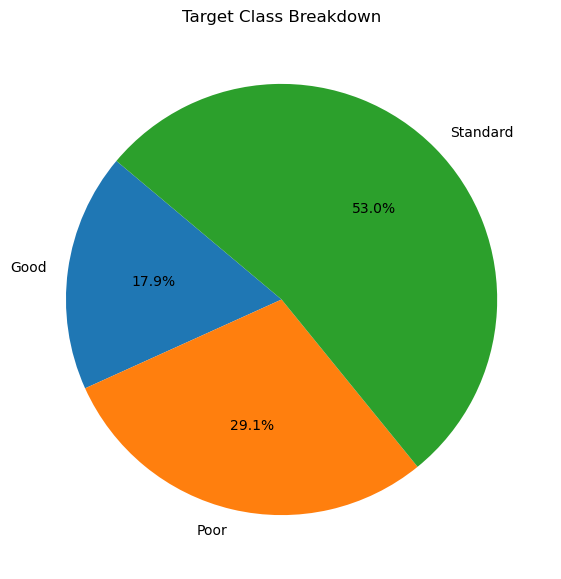

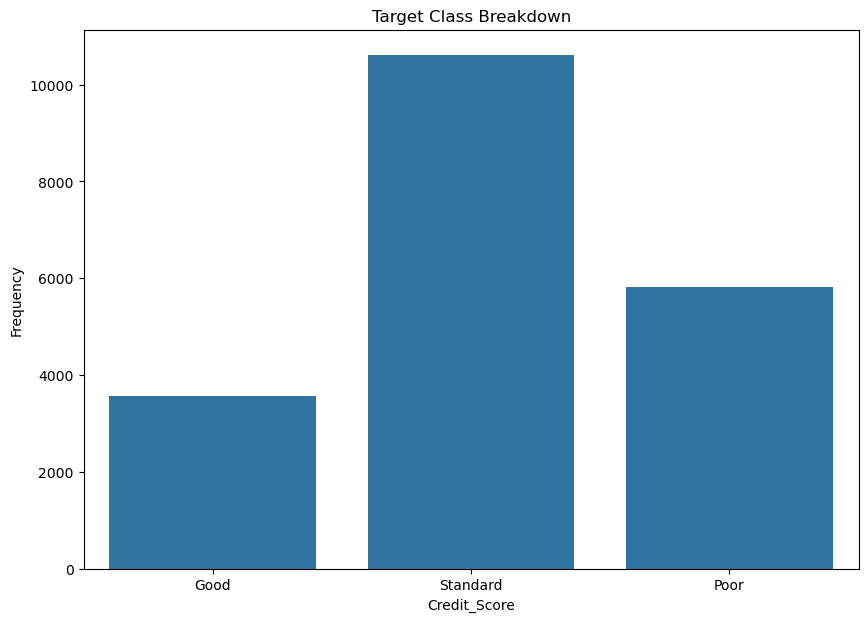

In [6]:
check_class_imbalance(df["Credit_Score"])

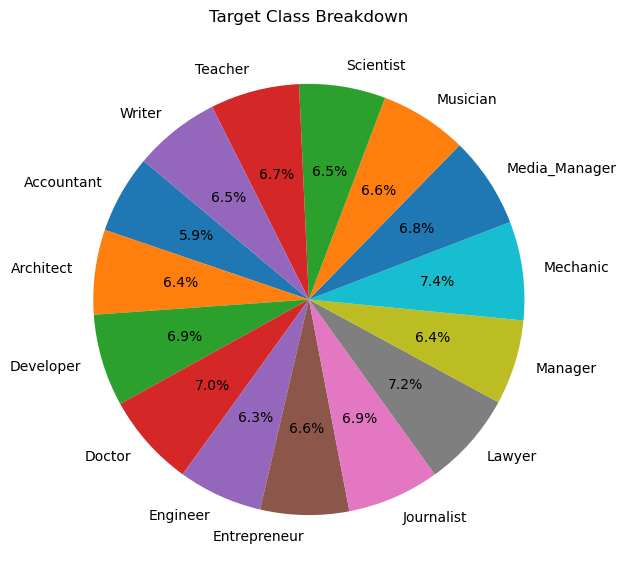

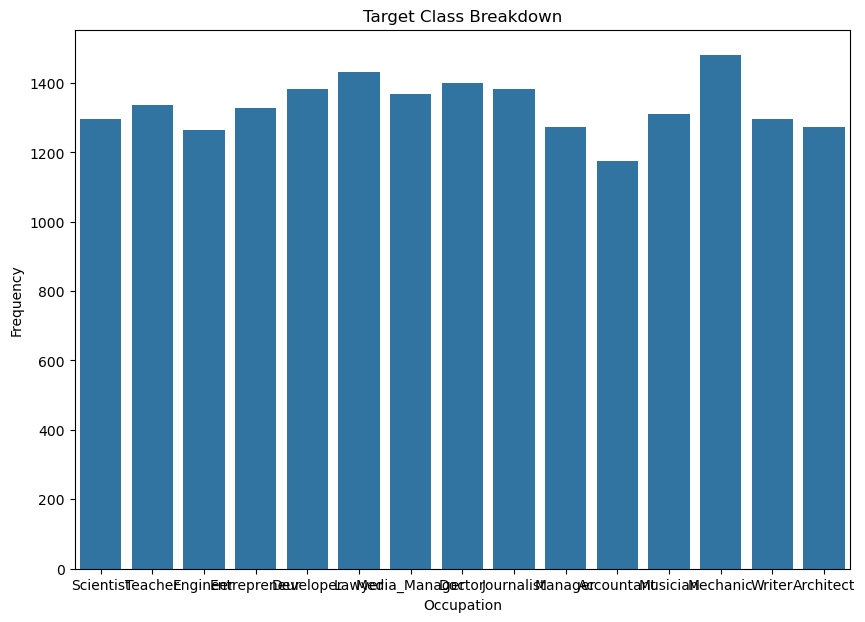

In [7]:
check_class_imbalance(df["Occupation"])

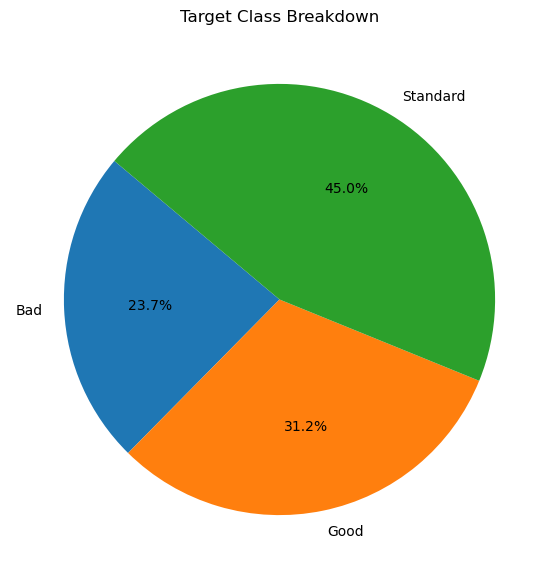

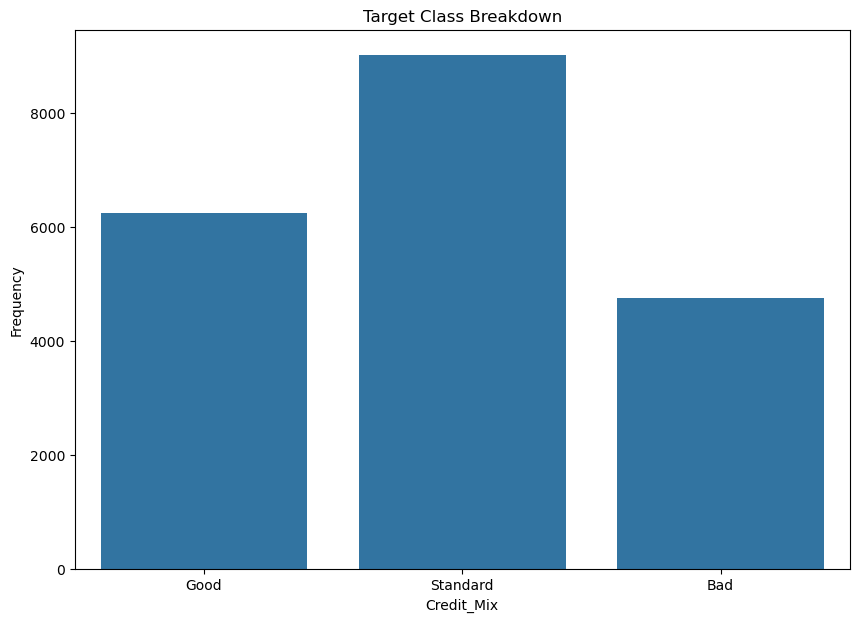

In [8]:
check_class_imbalance(df["Credit_Mix"])

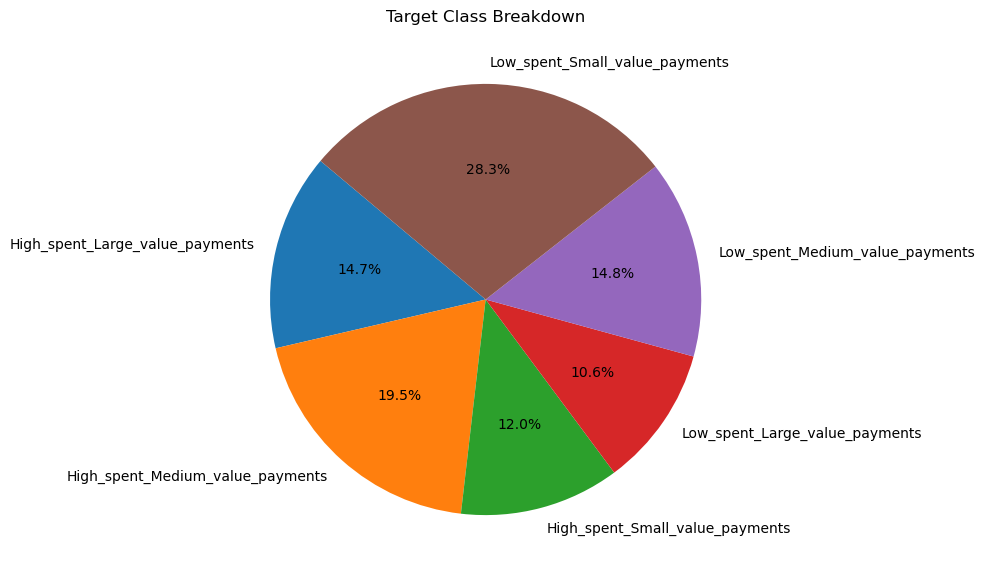

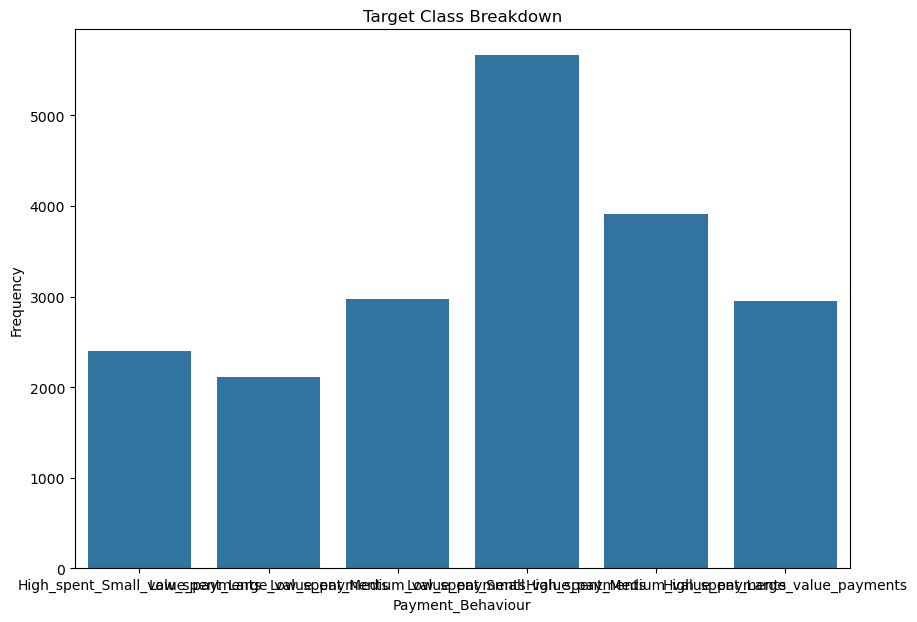

In [9]:
check_class_imbalance(df["Payment_Behaviour"])

In [10]:
df.dtypes

Age                         float64
Occupation                   object
Annual_Income               float64
Monthly_Inhand_Salary       float64
Num_Bank_Accounts           float64
Num_Credit_Card             float64
Interest_Rate               float64
Num_of_Loan                 float64
Delay_from_due_date         float64
Num_of_Delayed_Payment      float64
Changed_Credit_Limit        float64
Num_Credit_Inquiries        float64
Credit_Mix                   object
Outstanding_Debt            float64
Credit_Utilization_Ratio    float64
Credit_History_Age          float64
Payment_of_Min_Amount        object
Total_EMI_per_month         float64
Amount_invested_monthly     float64
Payment_Behaviour            object
Monthly_Balance             float64
Credit_Score                 object
dtype: object

In [11]:
df.describe()

Age  Annual_Income  Monthly_Inhand_Salary  Num_Bank_Accounts  \
count  20000.00000   20000.000000           20000.000000       20000.000000   
mean      33.33315   51424.071872            4272.929505           5.355000   
std       10.66952   38831.561503            3220.613912           2.621568   
min       14.00000    7006.520000             355.208333           0.000000   
25%       25.00000   19653.458750            1649.957500           3.000000   
50%       33.00000   38021.900000            3164.776667           6.000000   
75%       42.00000   73084.070000            6059.030000           7.000000   
max       56.00000  179987.280000           14866.446667          10.000000   

       Num_Credit_Card  Interest_Rate   Num_of_Loan  Delay_from_due_date  \
count      20000.00000   20000.000000  20000.000000         20000.000000   
mean           5.51020      14.348000      3.556000            21.089450   
std            2.04944       8.802612      2.425852            14.611821   
min            0.00000       1.000000      0.000000             0.000000   
25%            4.00000       7.000000      2.000000            10.000000   
50%            5.00000      13.000000      3.000000            18.000000   
75%            7.00000      20.000000      5.000000            28.000000   
max           11.00000      34.000000      9.000000            62.000000   

       Num_of_Delayed_Payment  Changed_Credit_Limit  Num_Credit_Inquiries  \
count            20000.000000          20000.000000           20000.00000   
mean                13.233750             10.379812               5.78540   
std                  6.241623              6.565820               3.91722   
min                  0.000000              0.500000               0.00000   
25%                  9.000000              5.370000               3.00000   
50%                 14.000000              9.250000               5.00000   
75%                 18.000000             14.710000               8.00000   
max                 25.000000             29.970000              17.00000   

       Outstanding_Debt  Credit_Utilization_Ratio  Credit_History_Age  \
count      20000.000000              20000.000000        20000.000000   
mean        1402.316992                 32.285886          222.208400   
std         1159.106816                  5.147183           98.145805   
min            1.480000                 20.000000            1.000000   
25%          542.407500                 27.990958          148.000000   
50%         1136.380000                 32.317460          219.000000   
75%         1872.072500                 36.528059          303.000000   
max         4998.070000                 50.000000          404.000000   

       Total_EMI_per_month  Amount_invested_monthly  Monthly_Balance  
count         20000.000000             20000.000000     20000.000000  
mean            110.488291                56.137823       392.998012  
std             136.658493                39.890532       202.280870  
min               0.000000                 0.000000         0.103402  
25%              28.859890                28.017447       268.269863  
50%              66.917525                46.286727       334.365289  
75%             153.446082                72.718981       463.991700  
max            1679.017067               434.191089      1183.930696

In [12]:
numeric_cols = df.select_dtypes(include=["int64", "float64"])
cat_cols = df.select_dtypes(include=["object"]).drop("Credit_Score", axis=1)

# Heat Map

<AxesSubplot:>

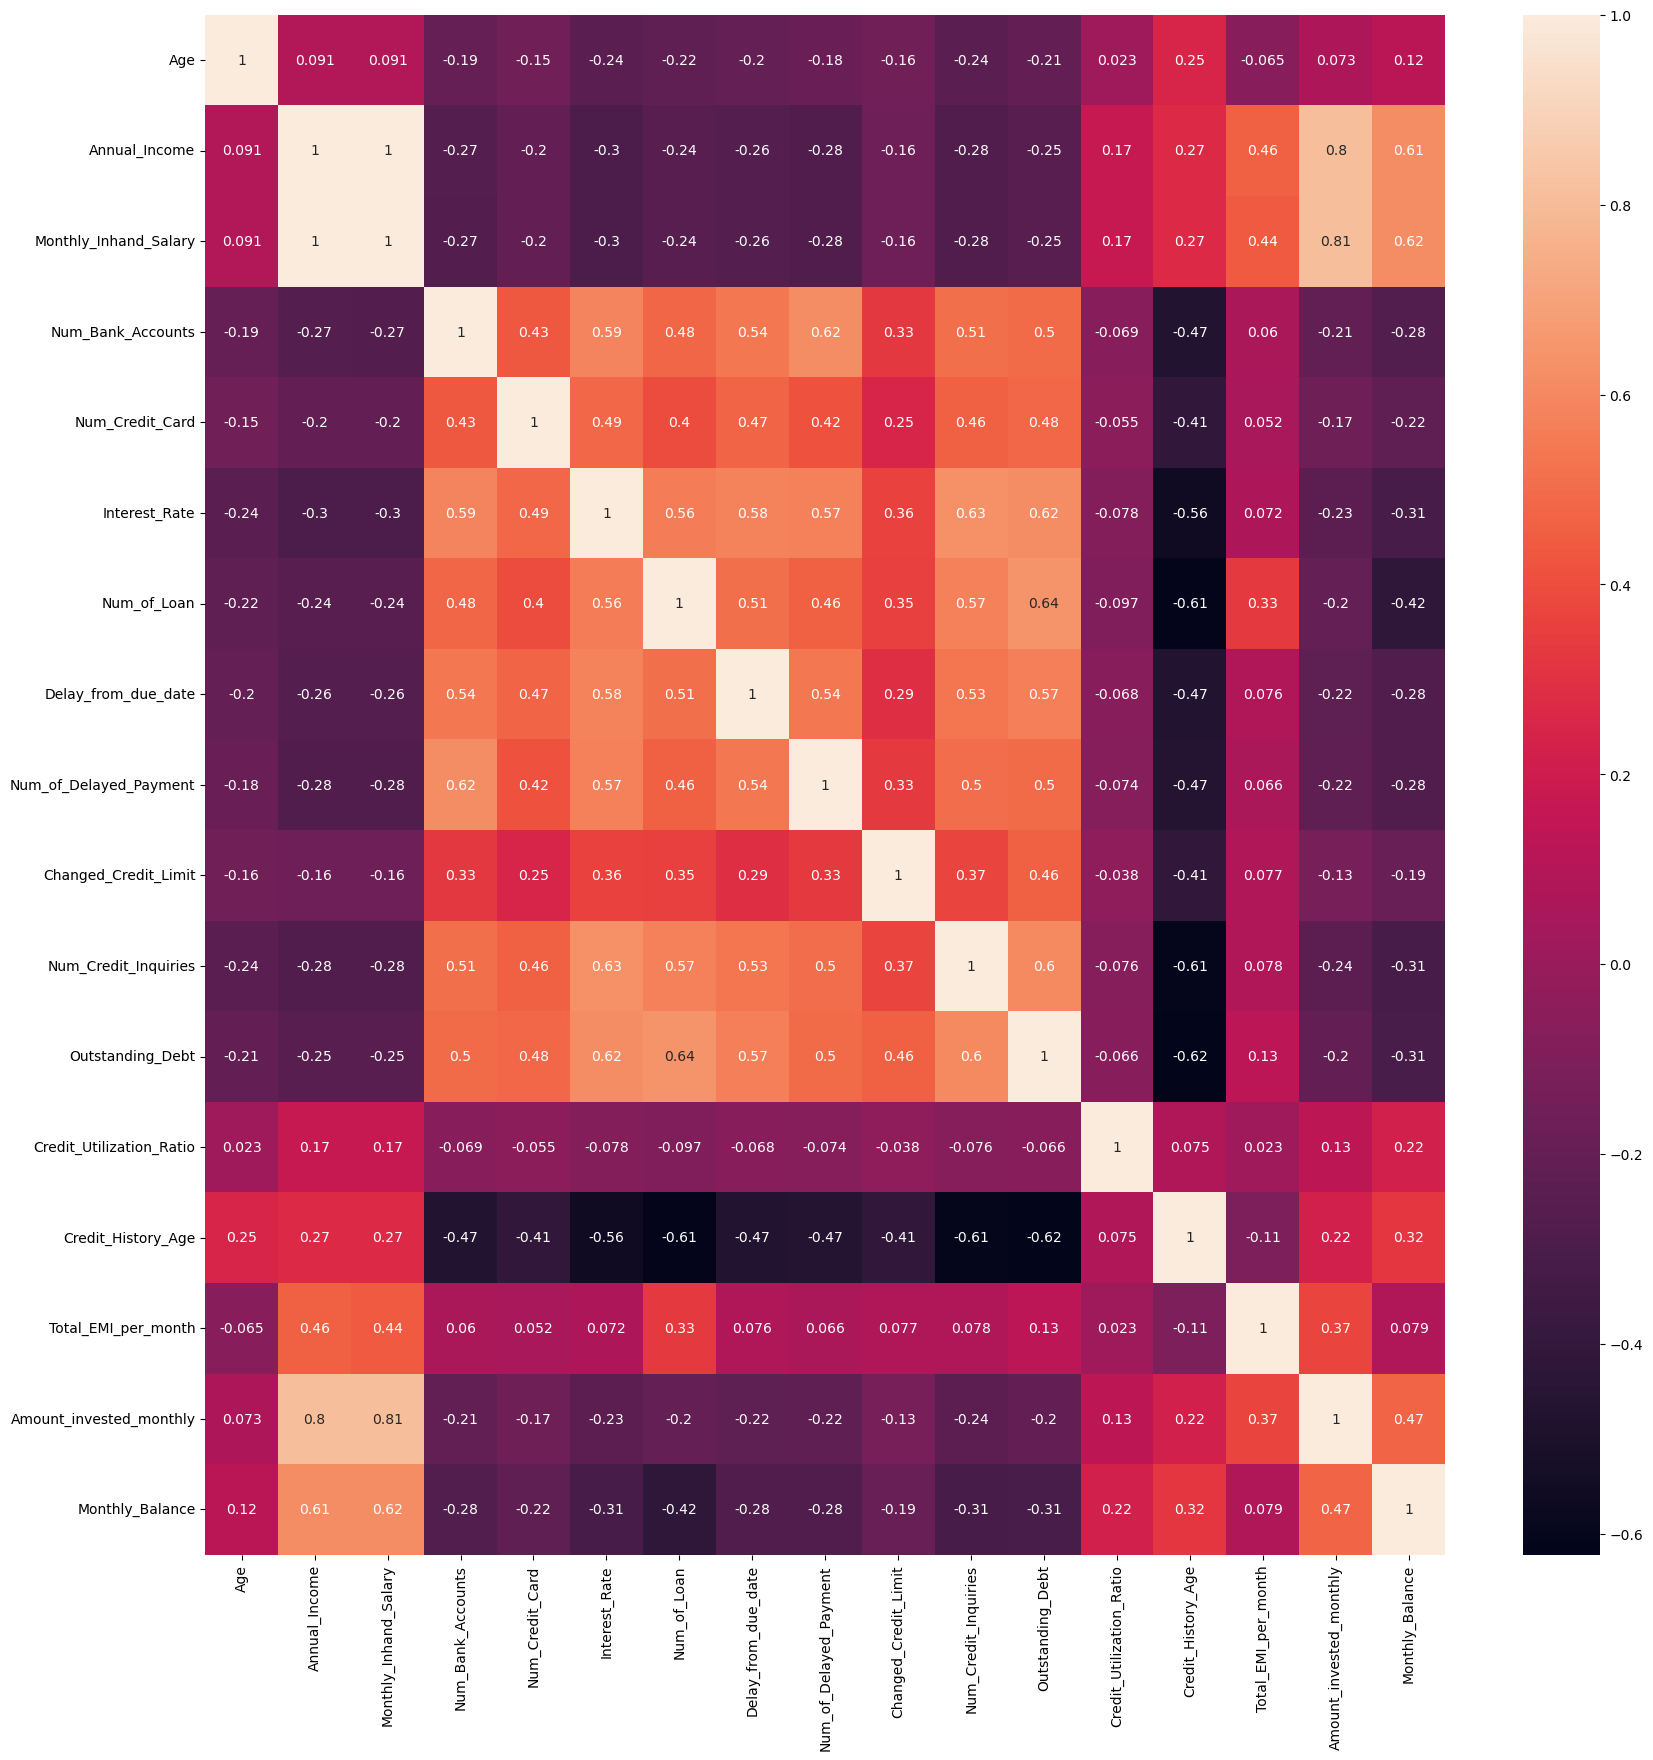

In [13]:
relations = numeric_cols.corr()
plt.figure(figsize=(20,20))
sns.heatmap(data=relations, annot=True)

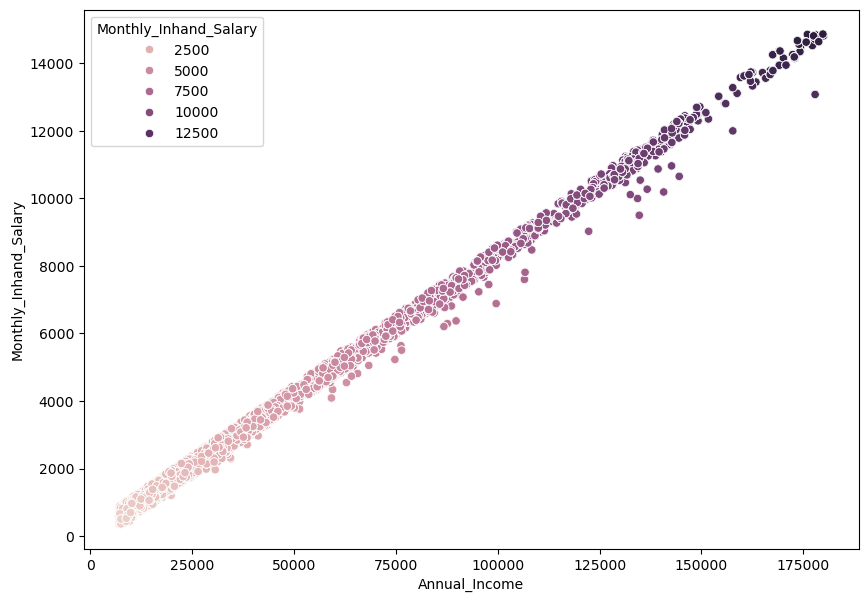

In [14]:
plt.figure(figsize=(10,7))
sns.scatterplot(data=df, x="Annual_Income", y="Monthly_Inhand_Salary", hue="Monthly_Inhand_Salary")
plt.show()

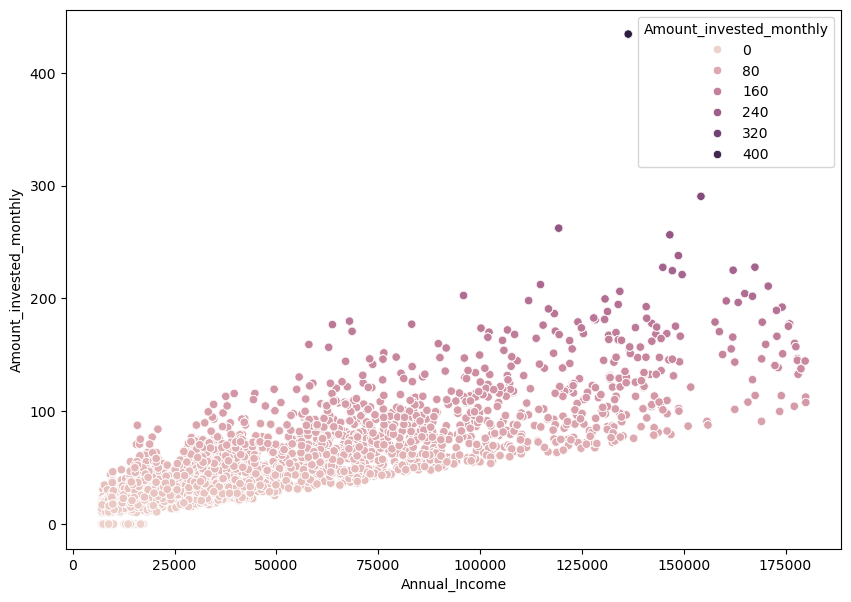

In [15]:
plt.figure(figsize=(10,7))
sns.scatterplot(data=df, x="Annual_Income", y="Amount_invested_monthly", hue="Amount_invested_monthly")
plt.show()

# Histogram Visuals

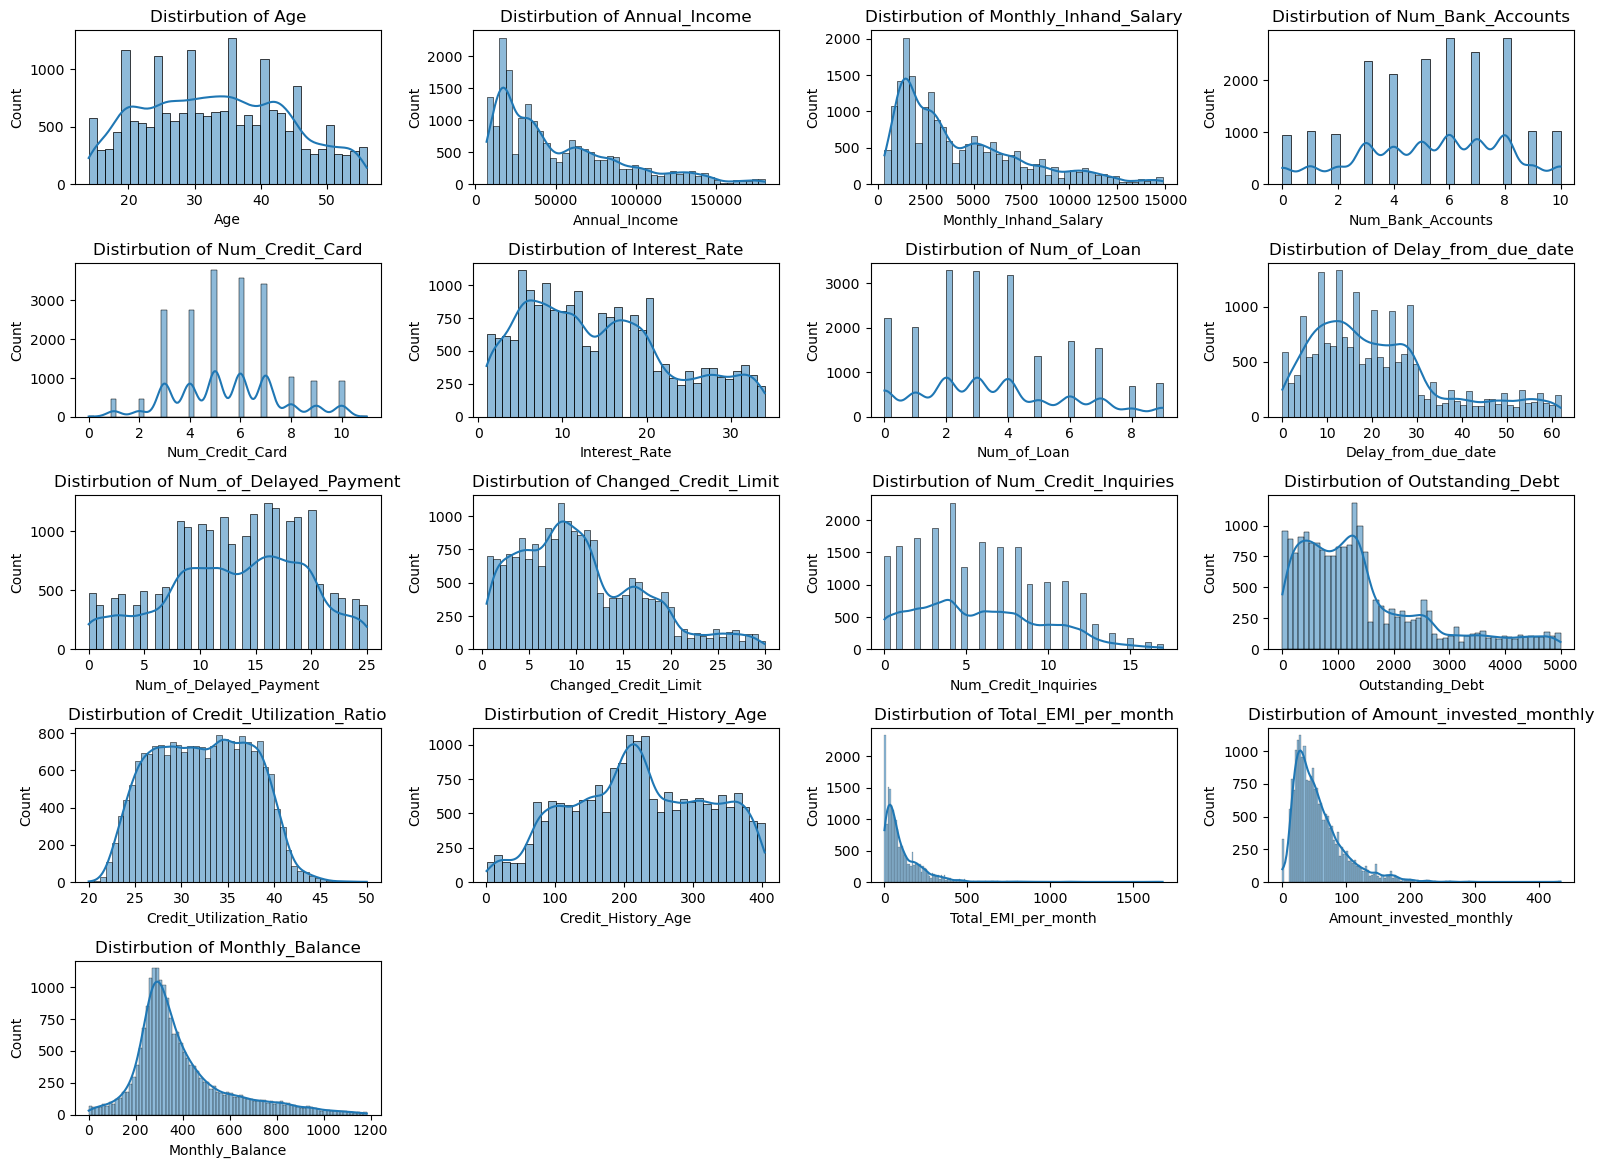

In [16]:
plot_distribution(numeric_cols, "hist")

# Box Plot

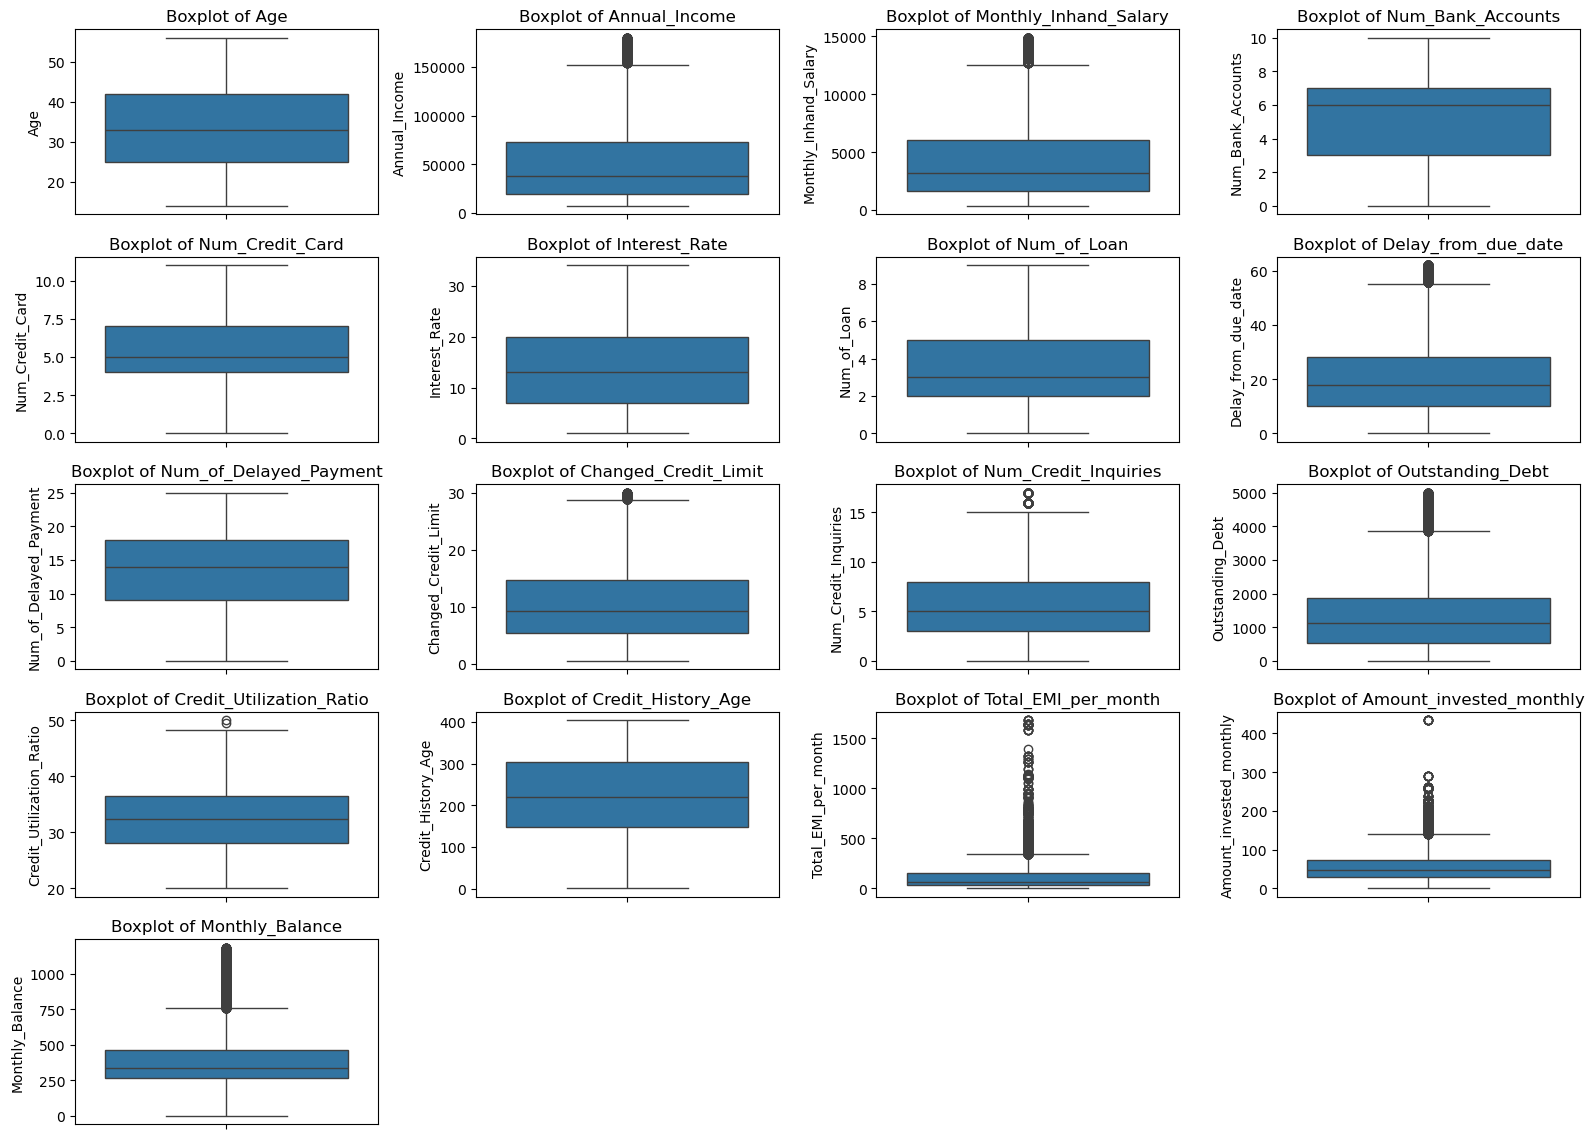

In [17]:
plot_distribution(numeric_cols, "boxplot")

# Data Follows A Power Law Dist

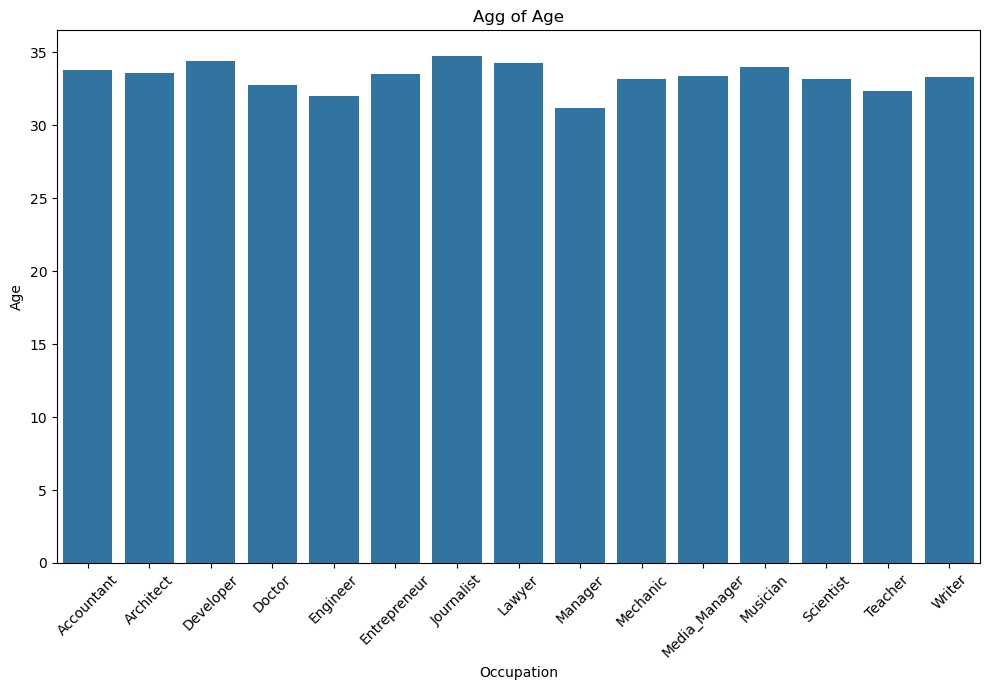

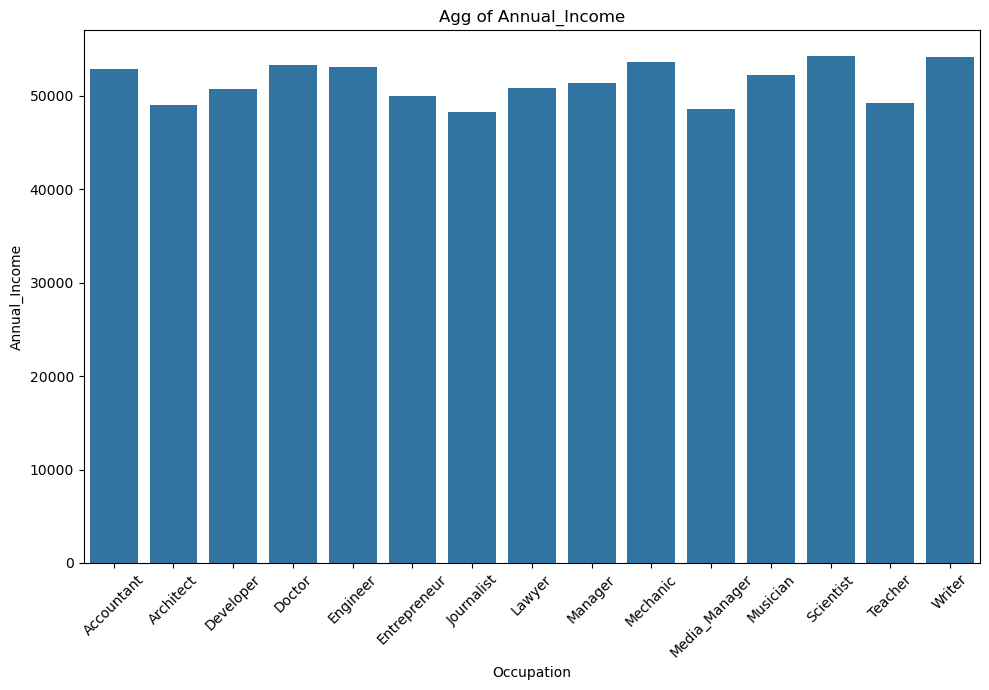

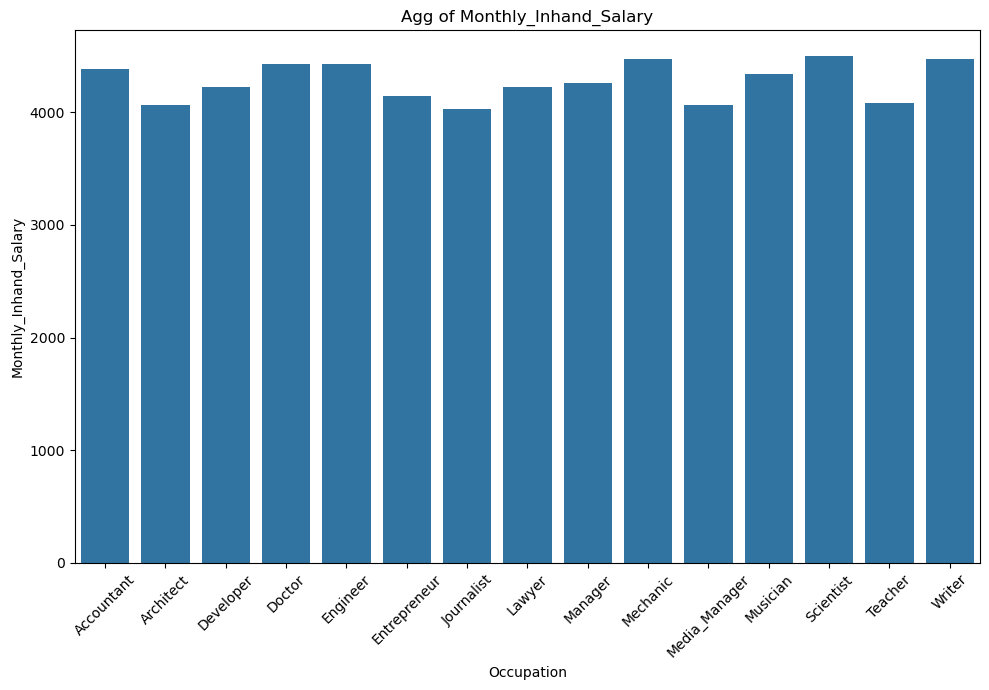

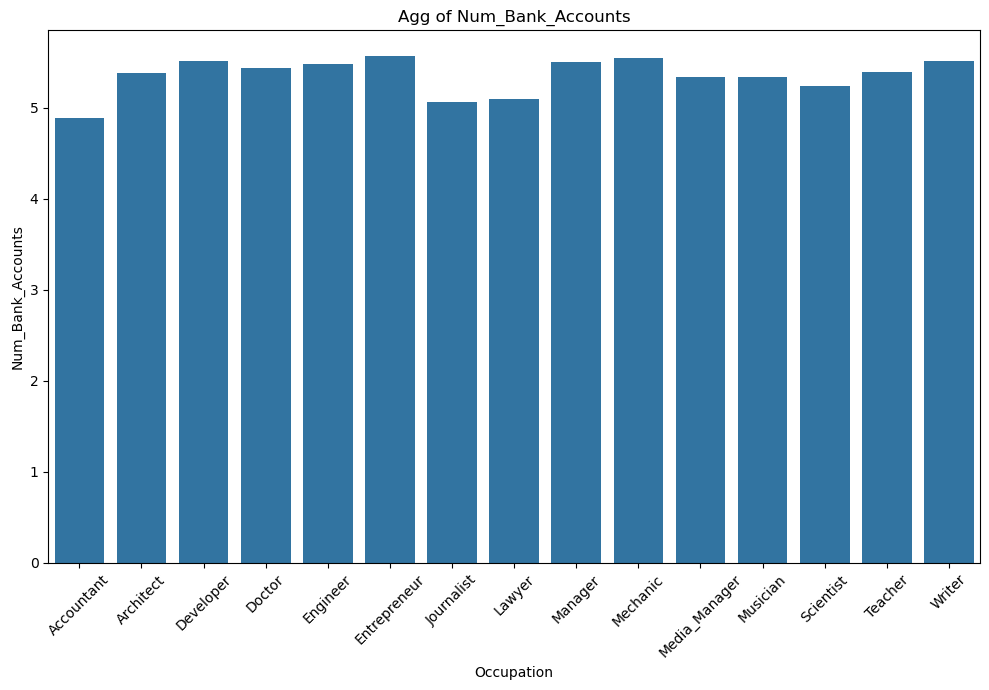

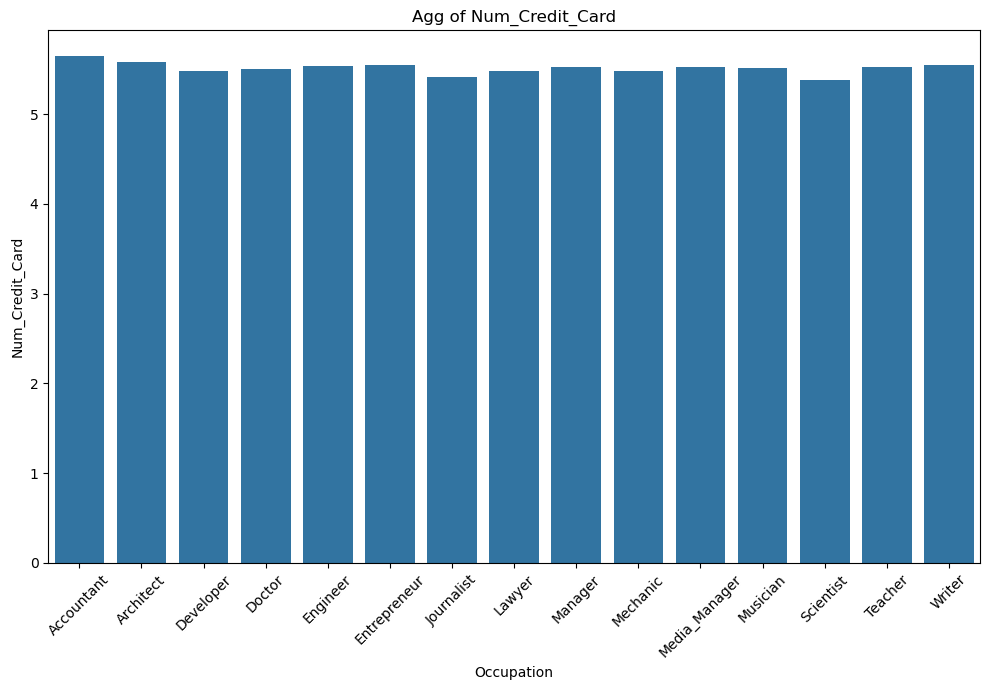

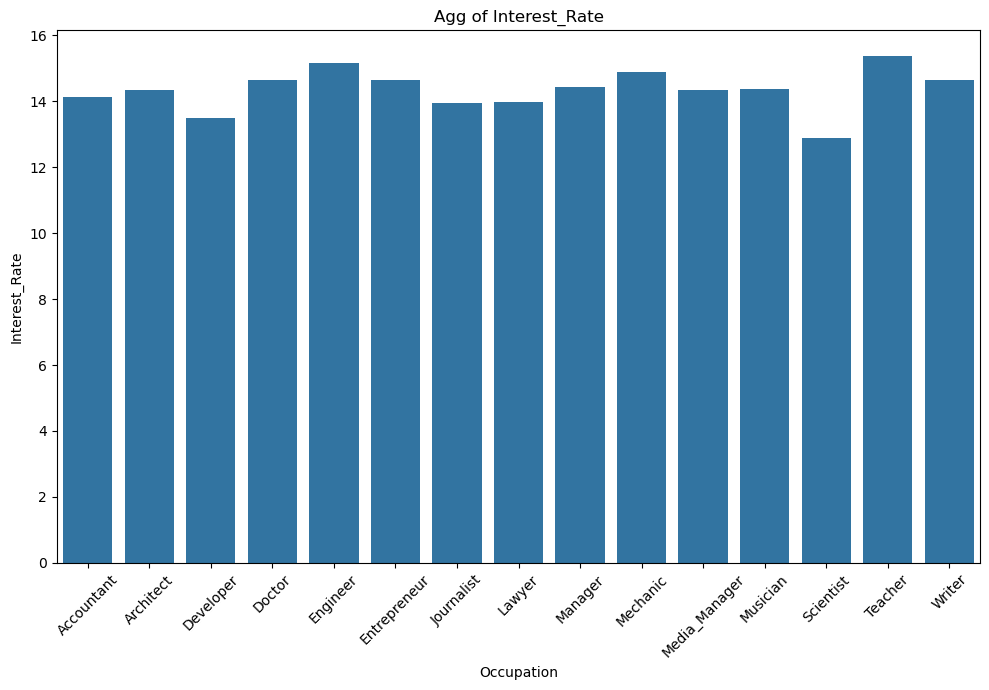

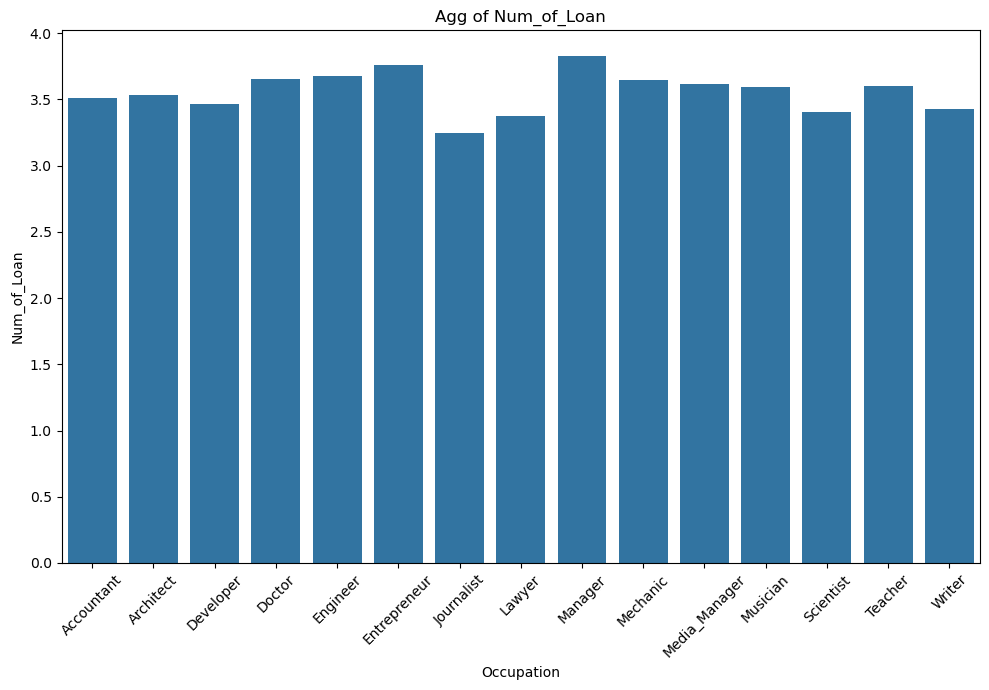

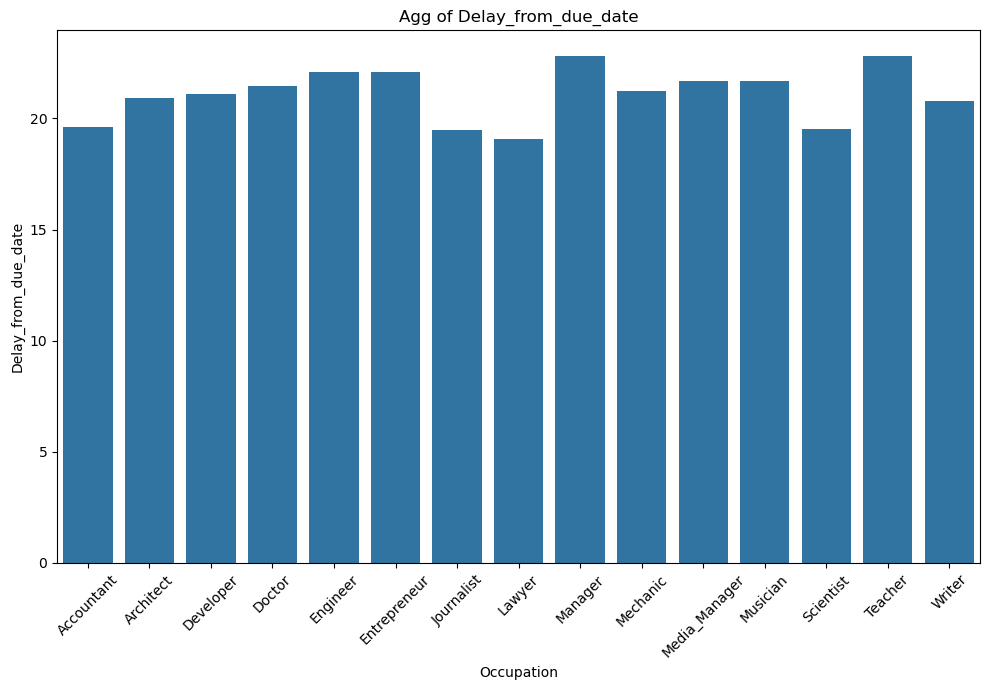

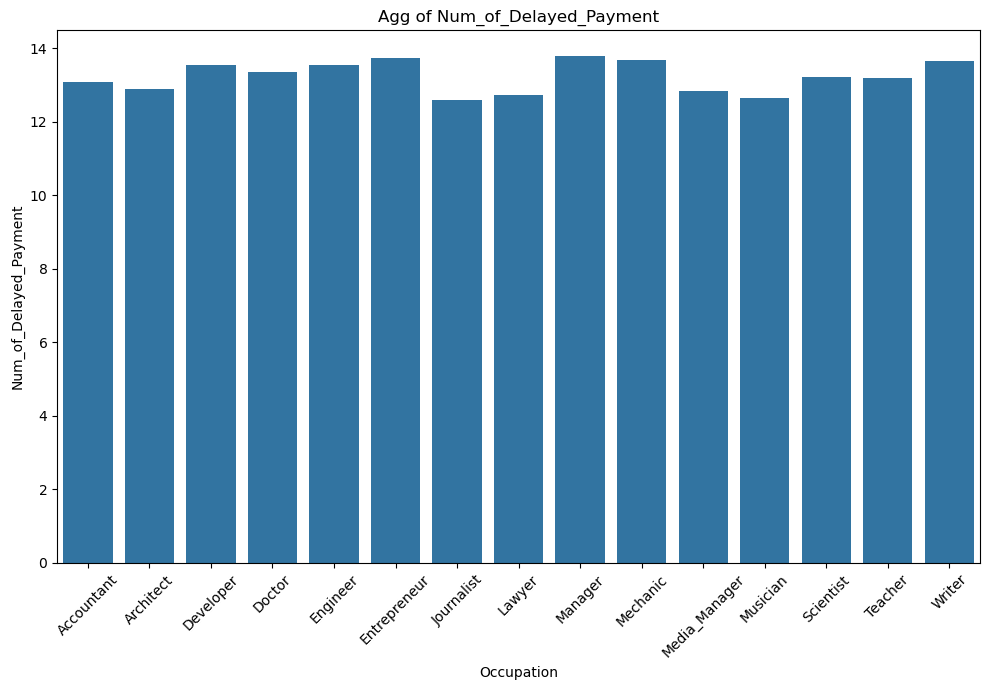

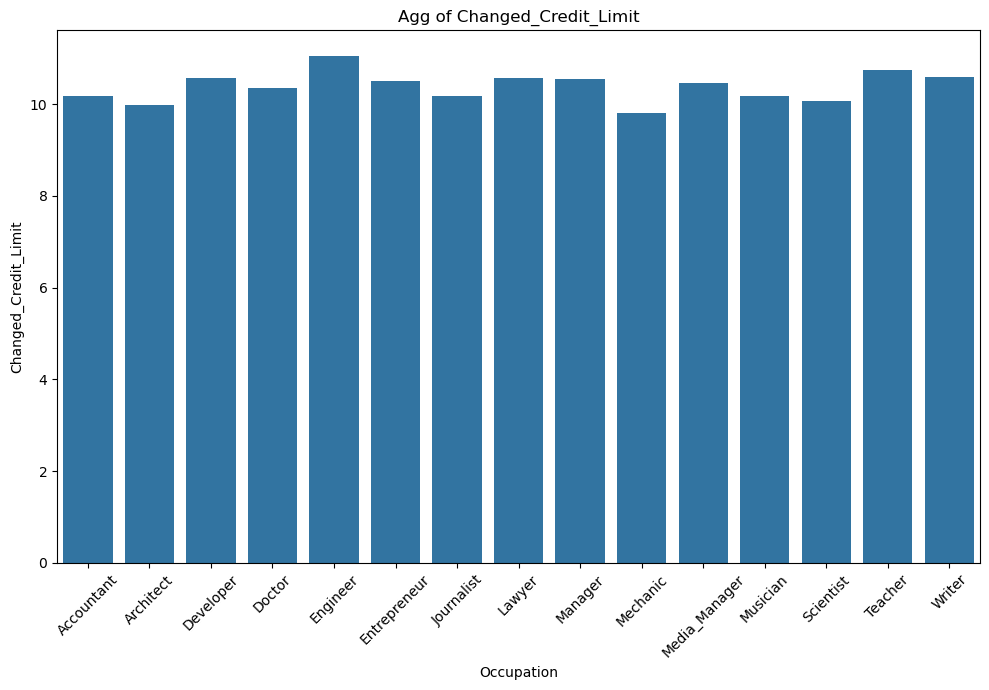

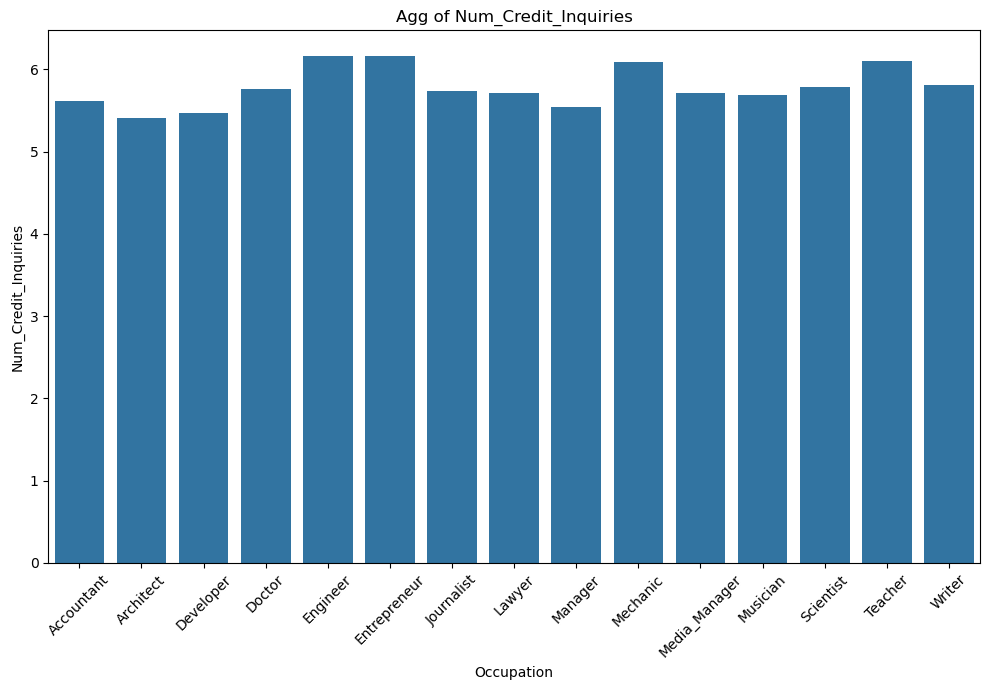

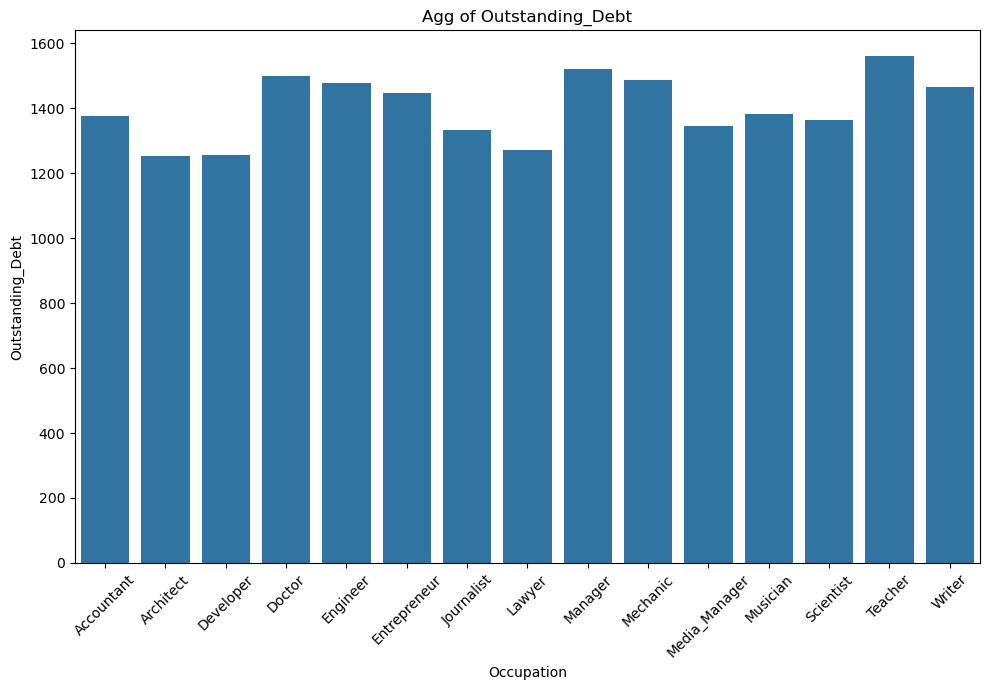

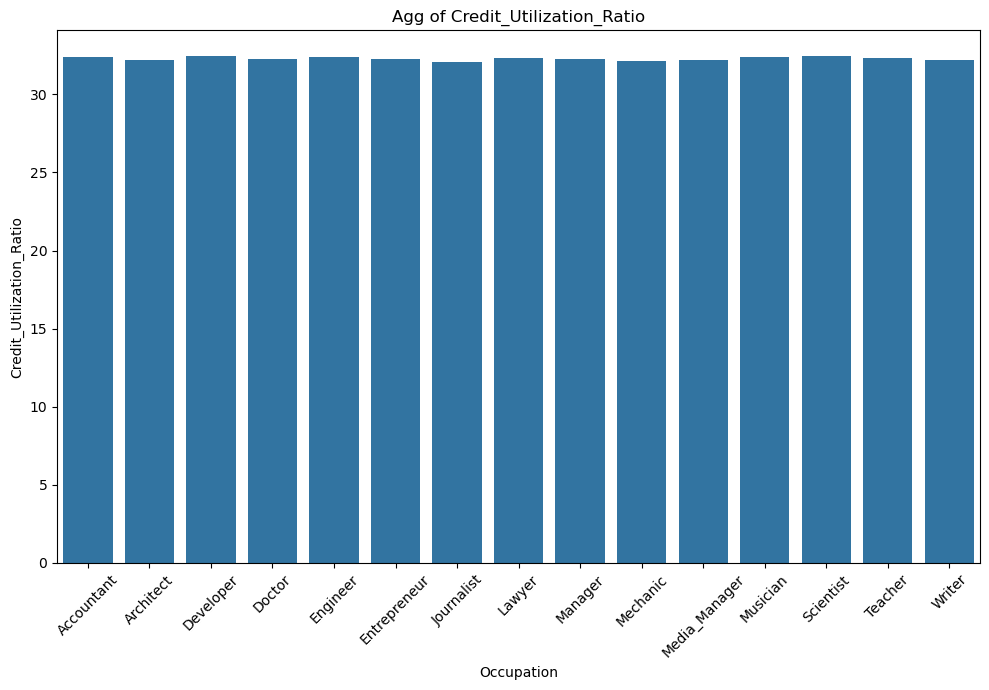

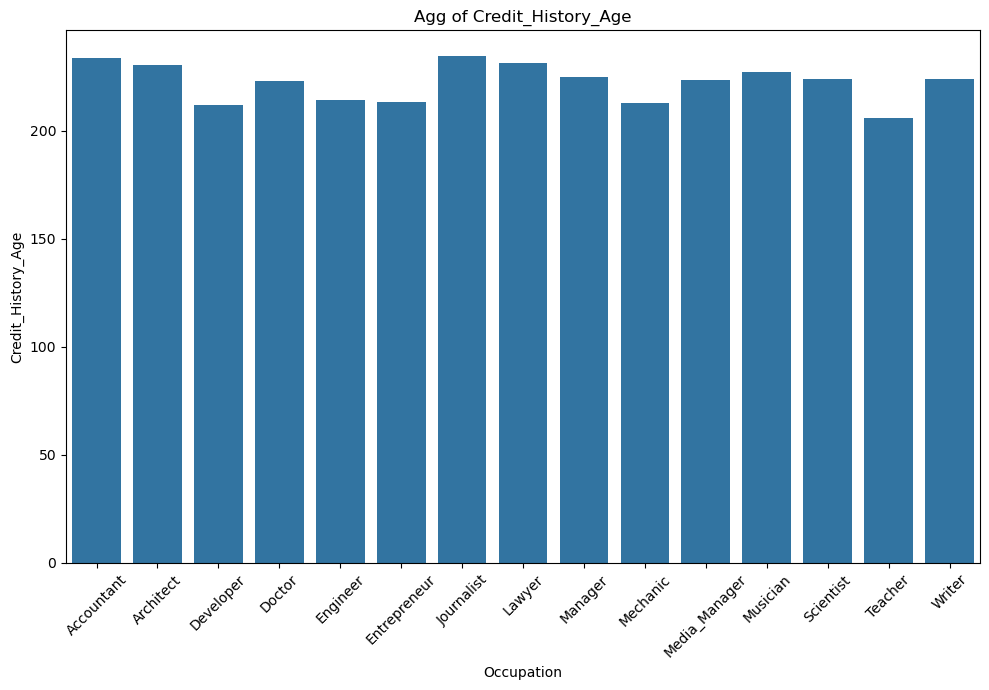

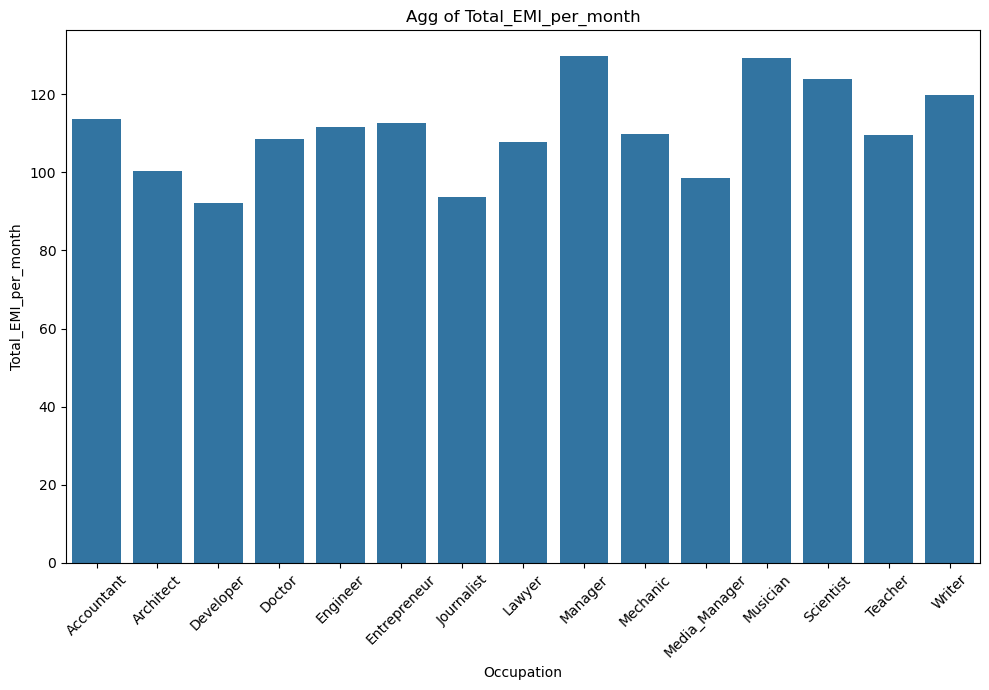

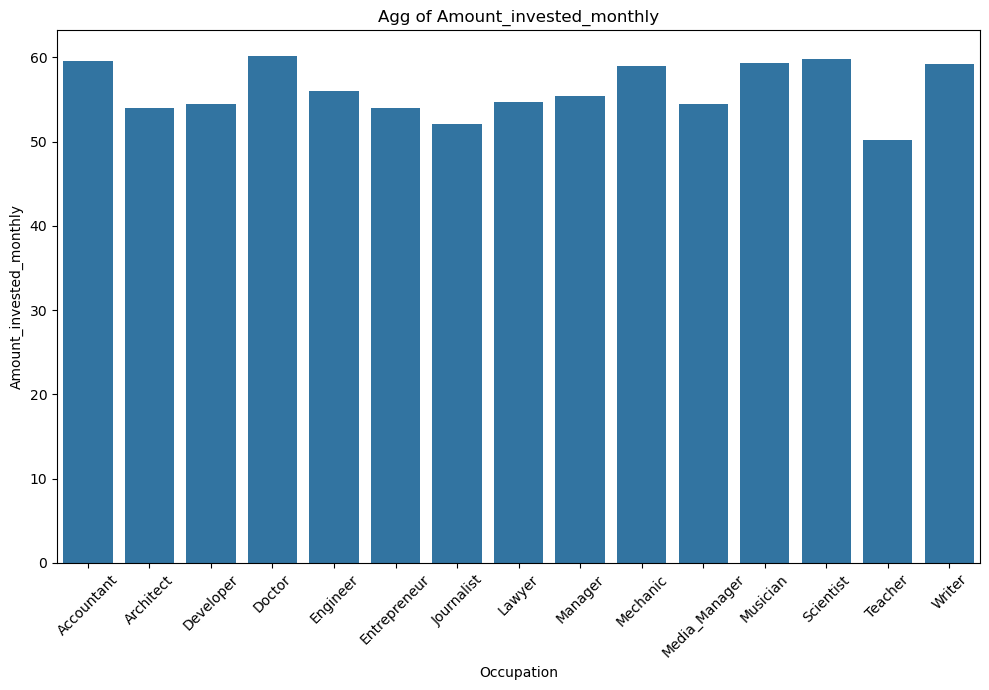

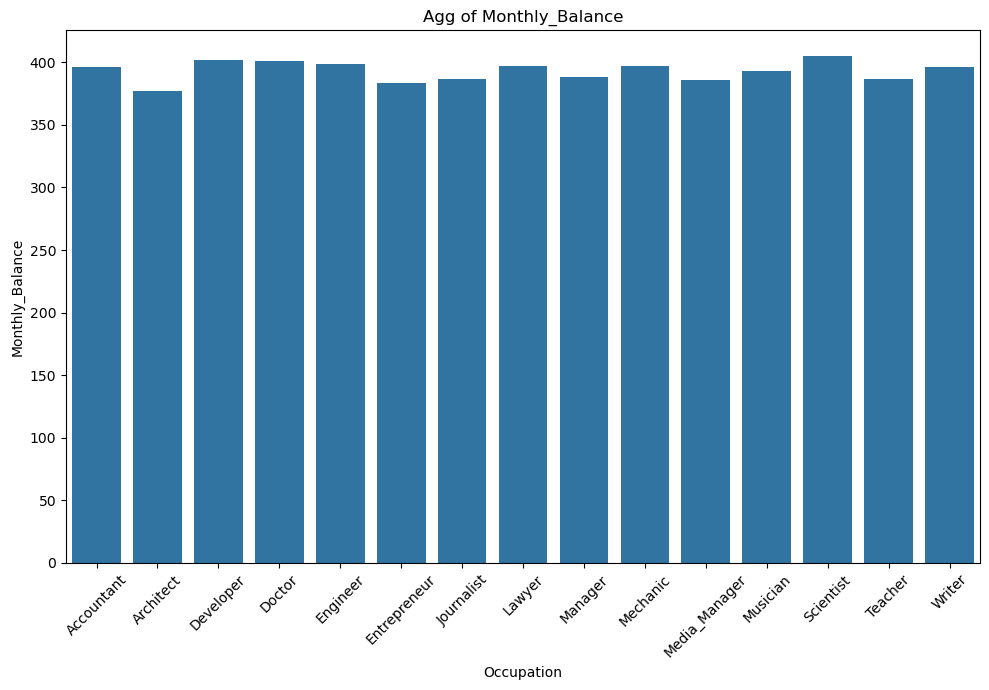

In [18]:
for col in numeric_cols.columns:
  aggregate_dataset(df, "Occupation", col, "mean")

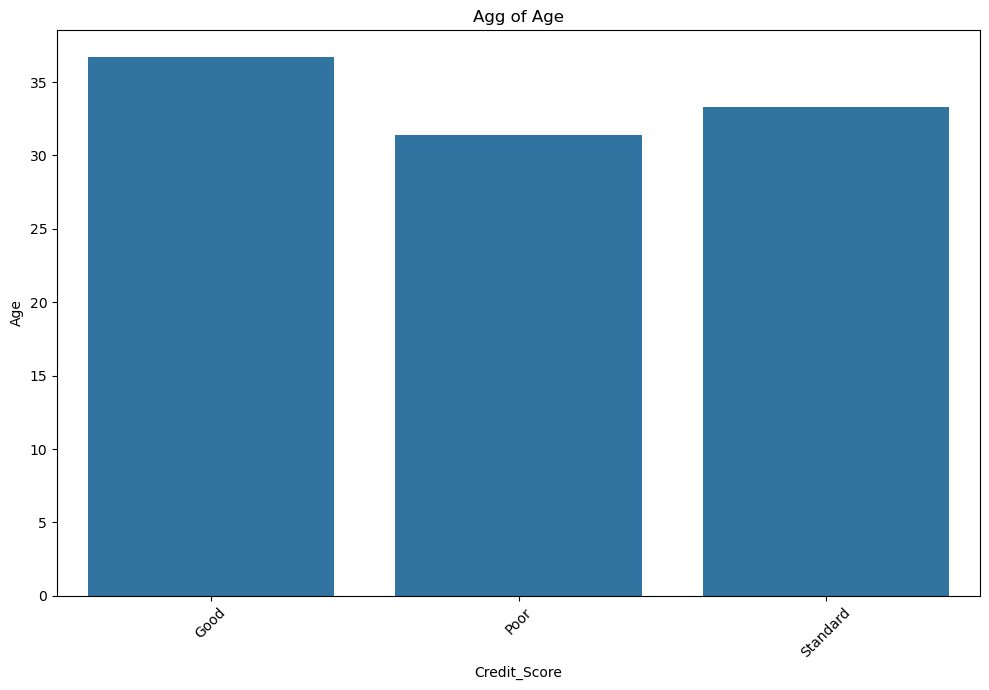

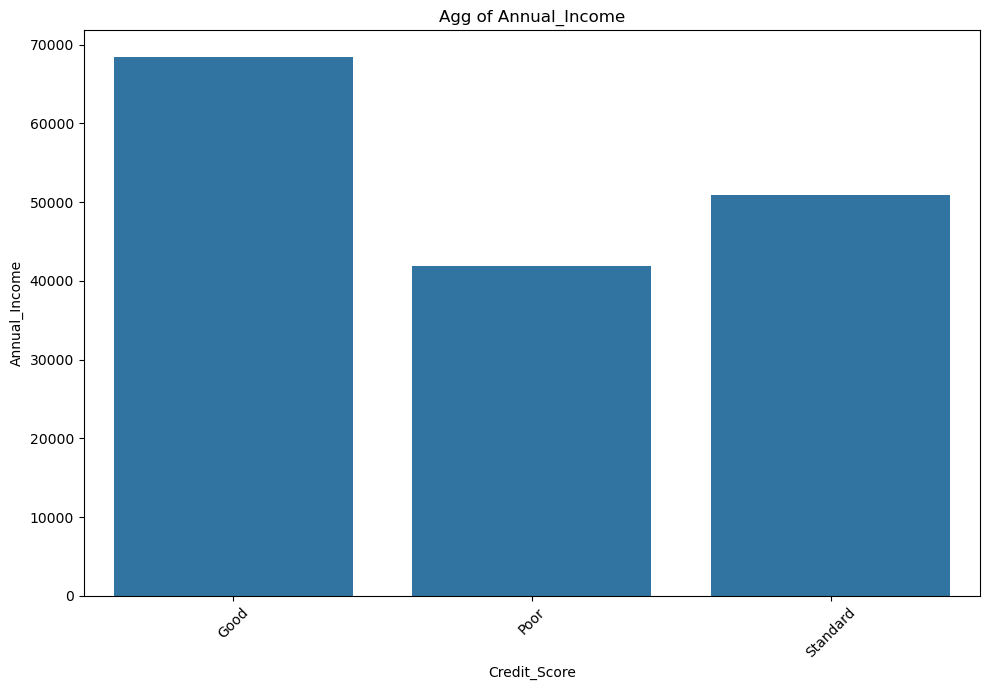

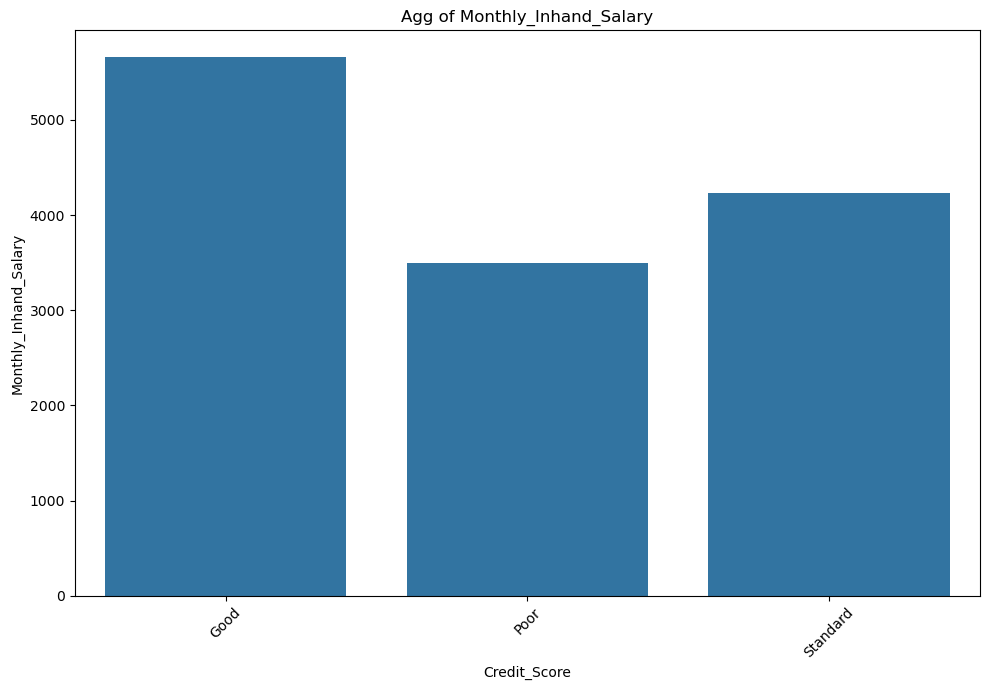

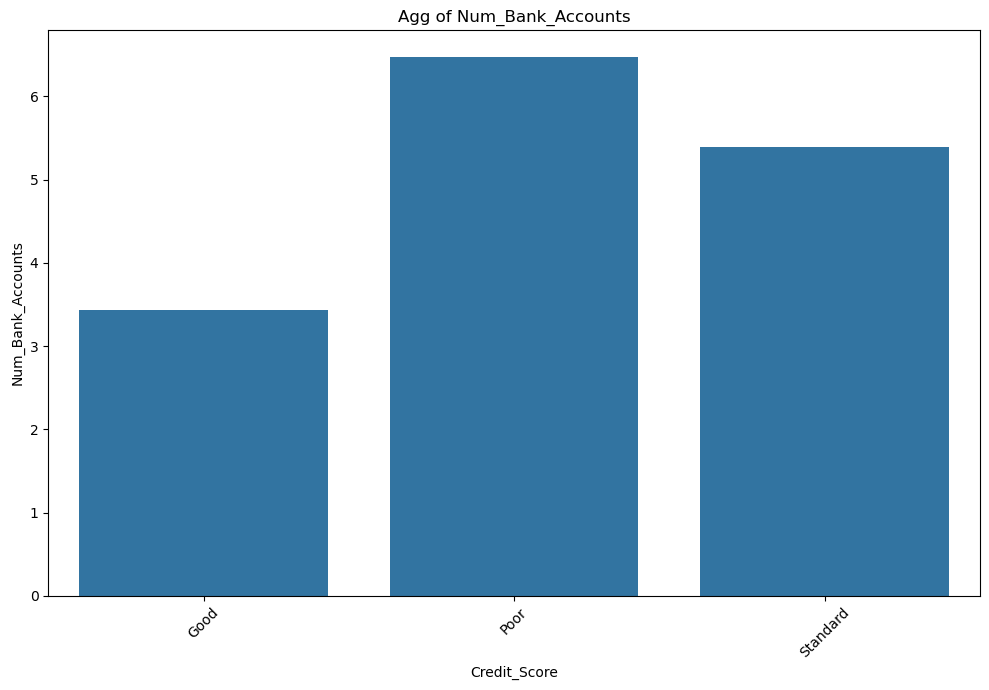

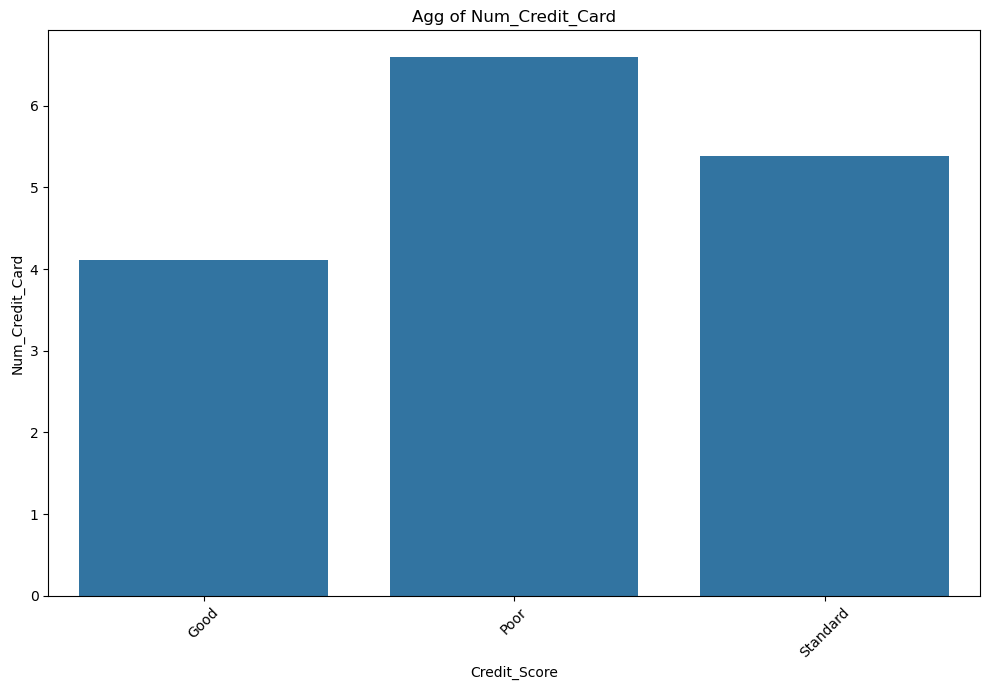

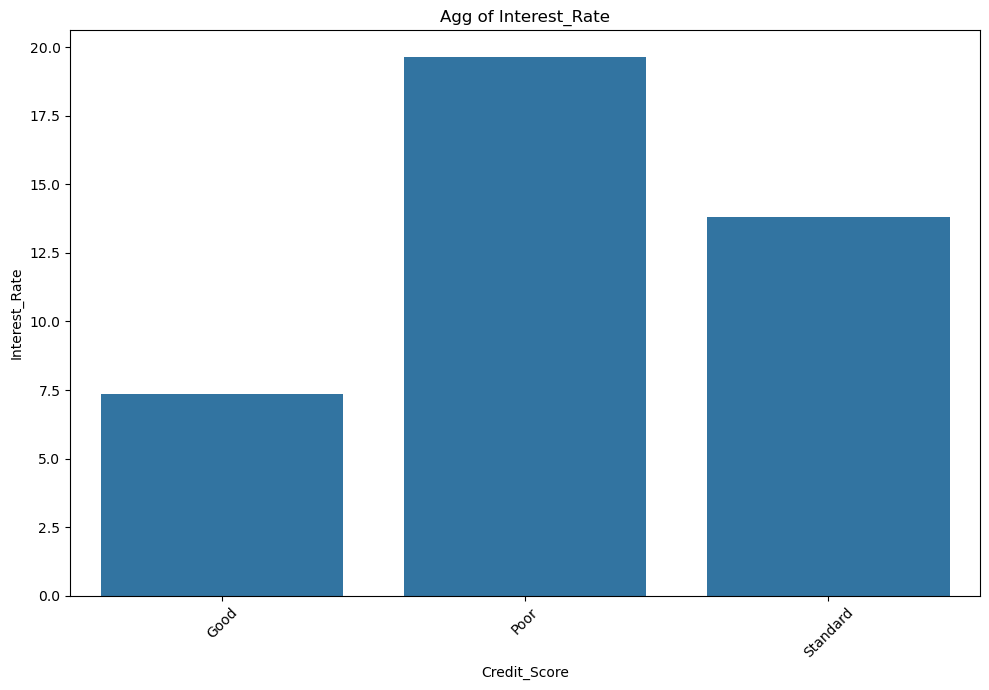

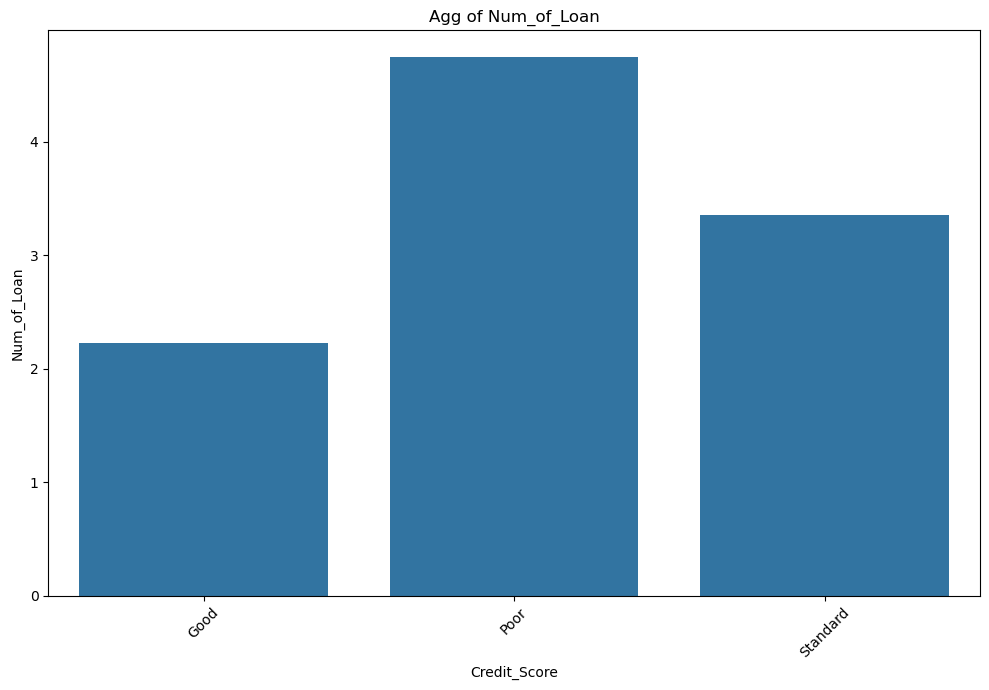

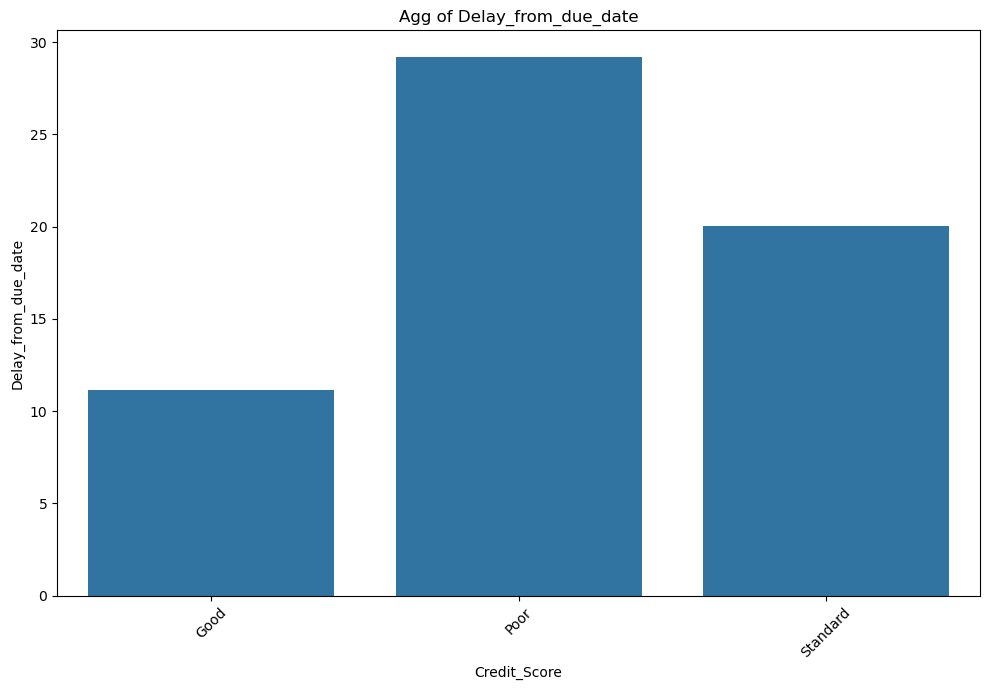

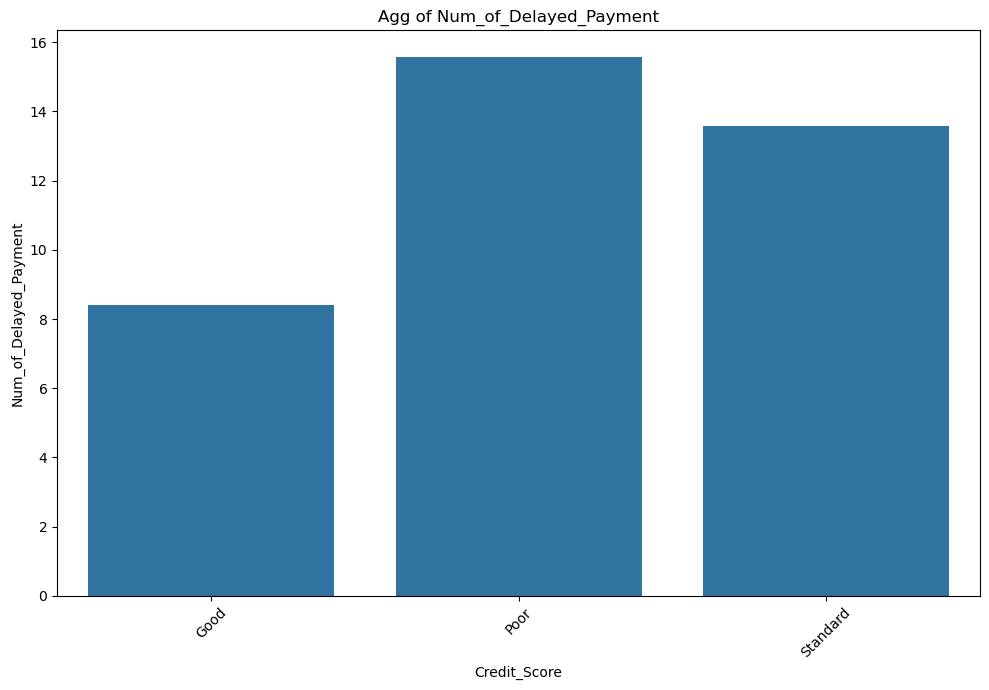

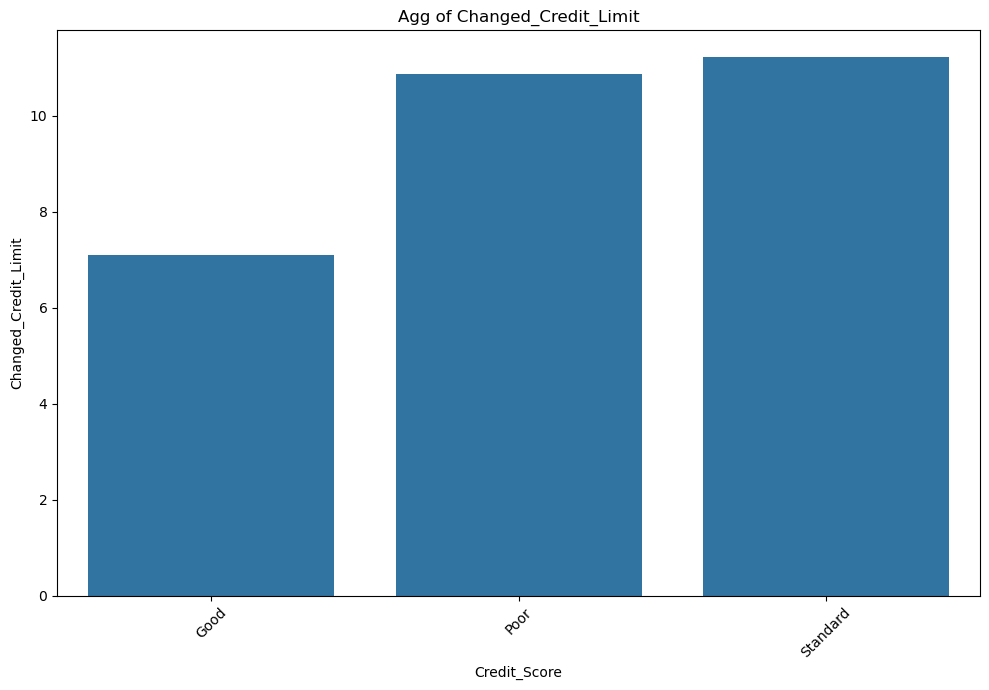

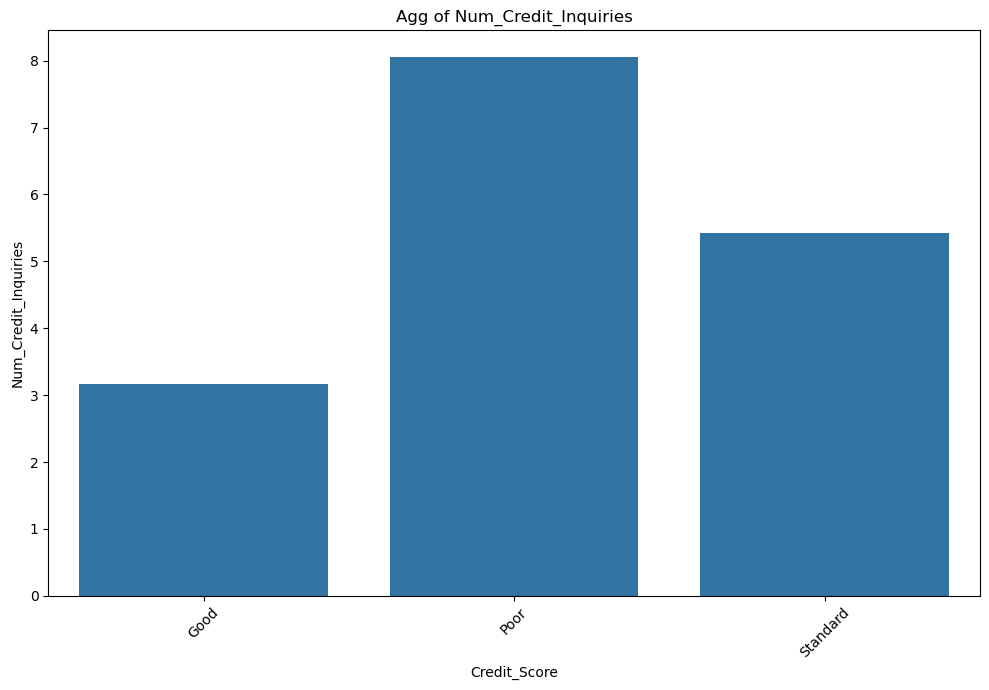

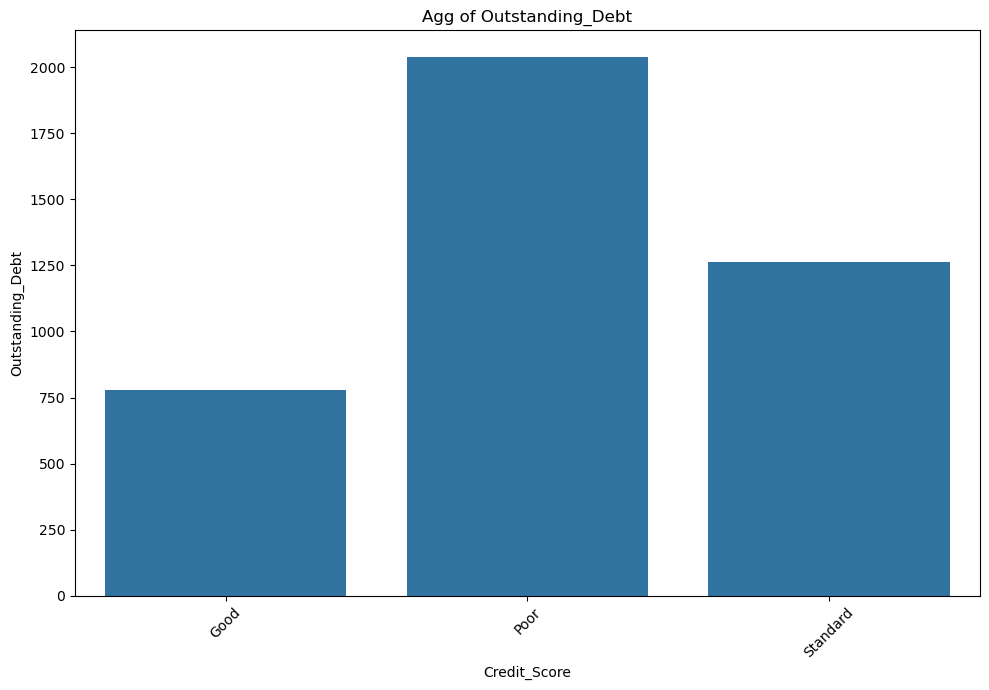

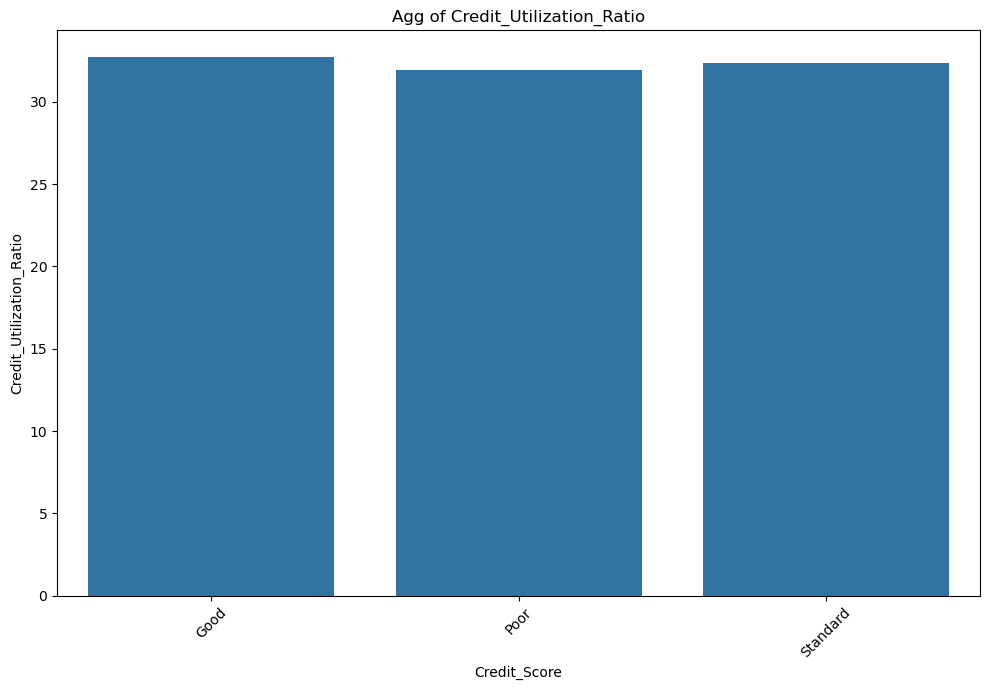

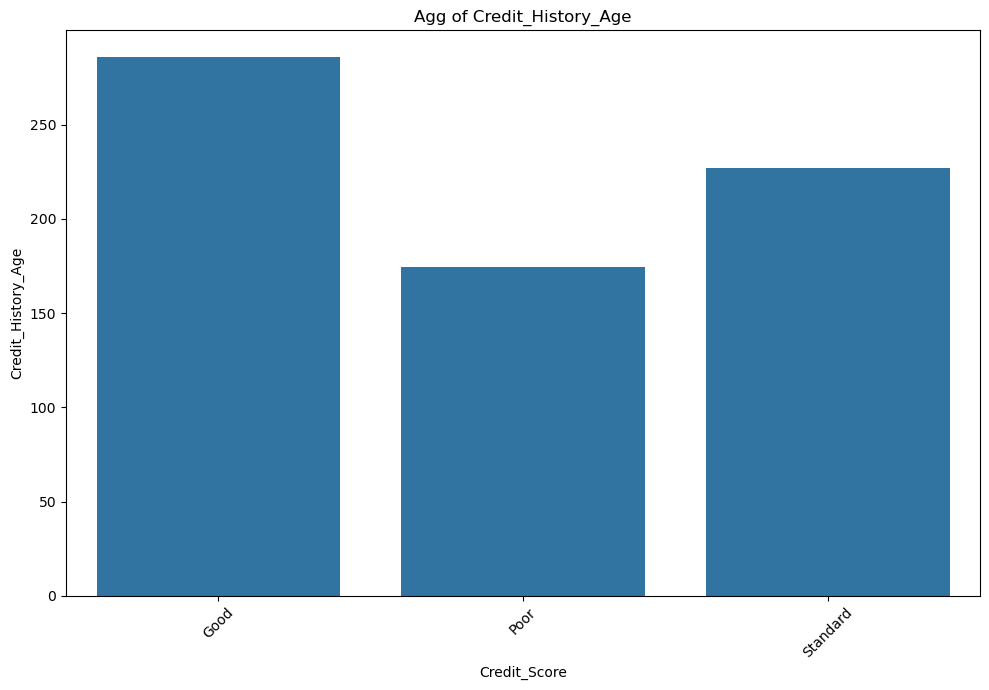

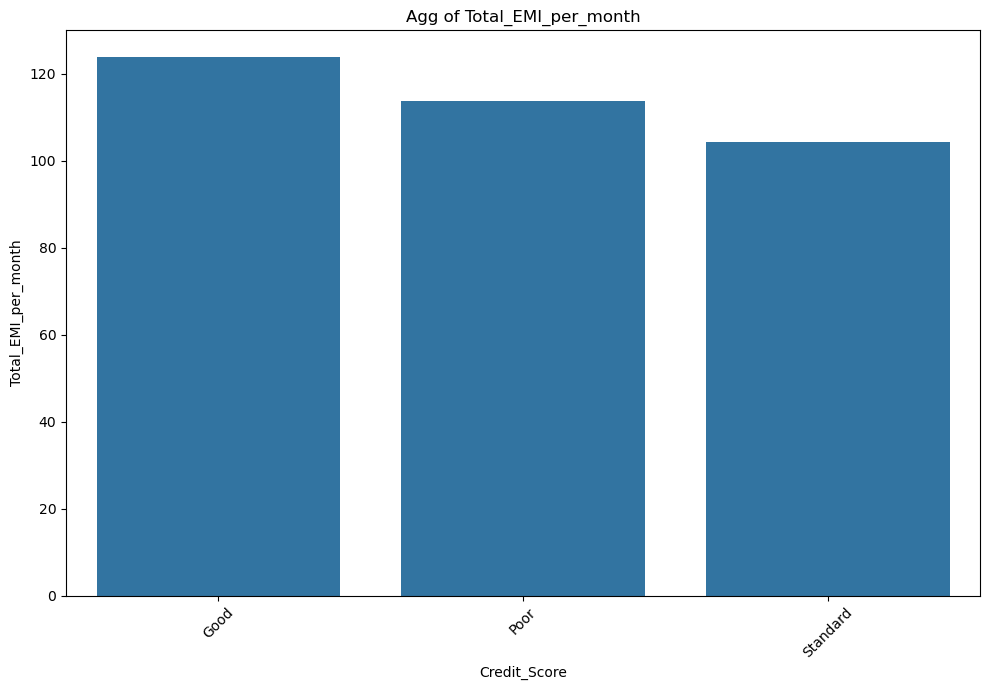

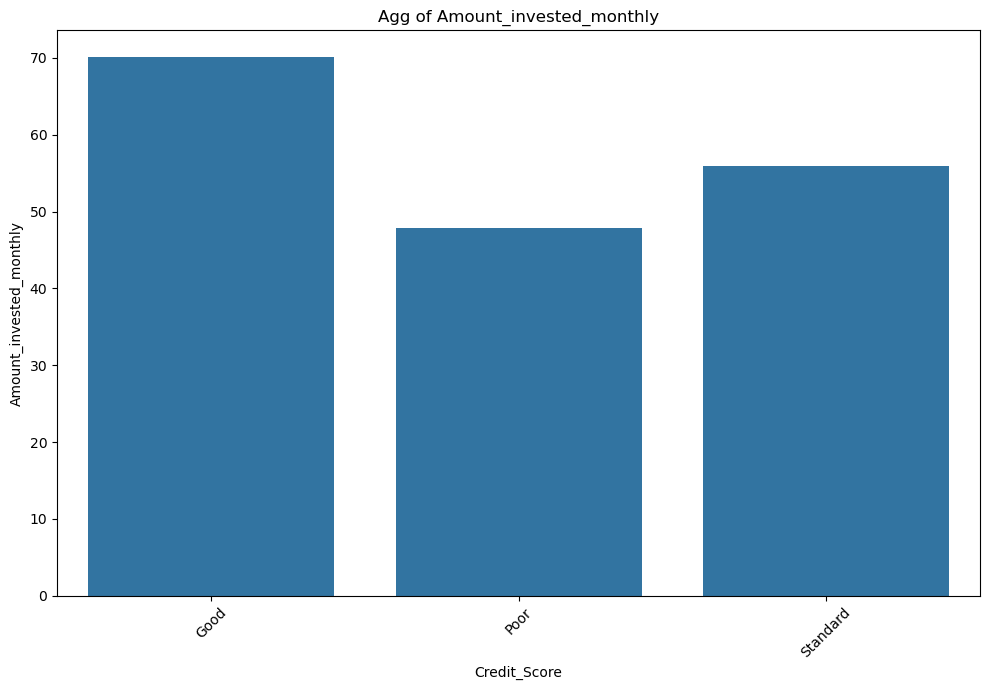

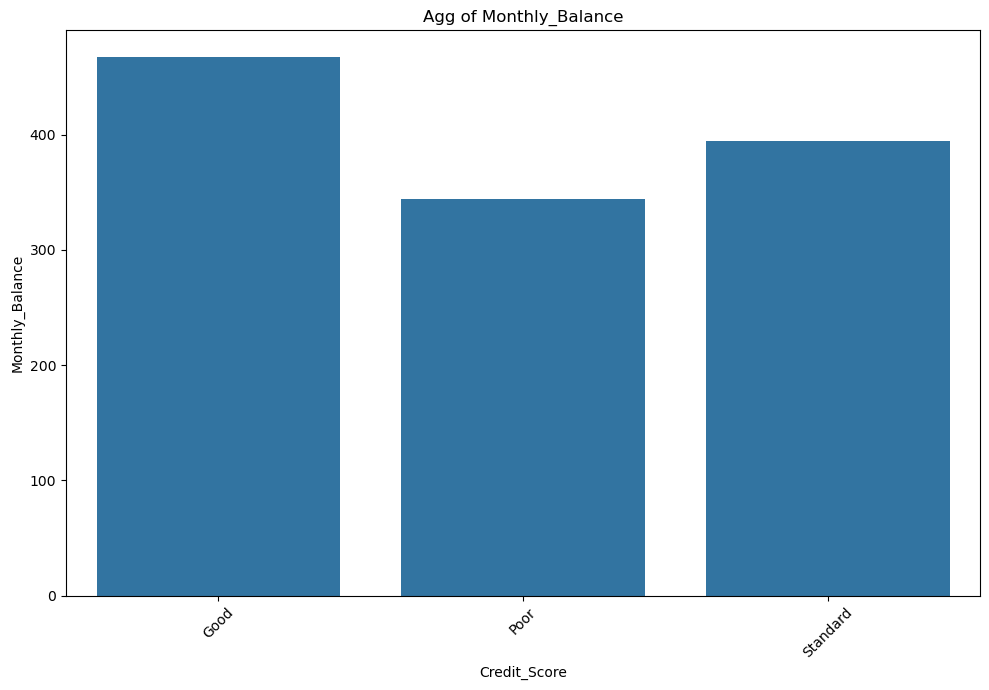

In [19]:
for col in numeric_cols.columns:
  aggregate_dataset(df, "Credit_Score", col, "mean")

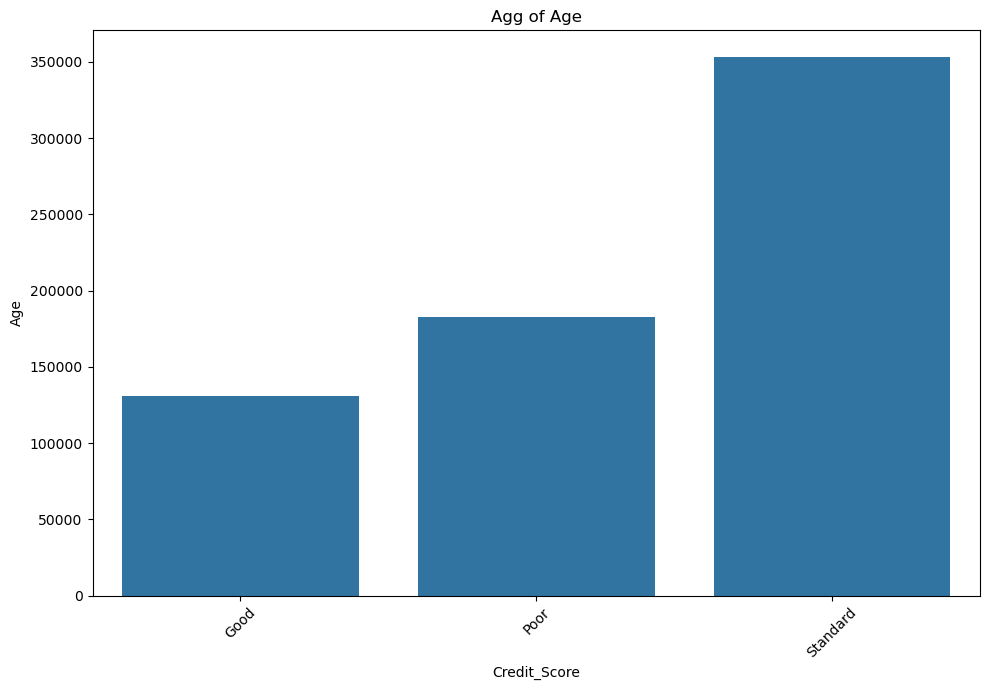

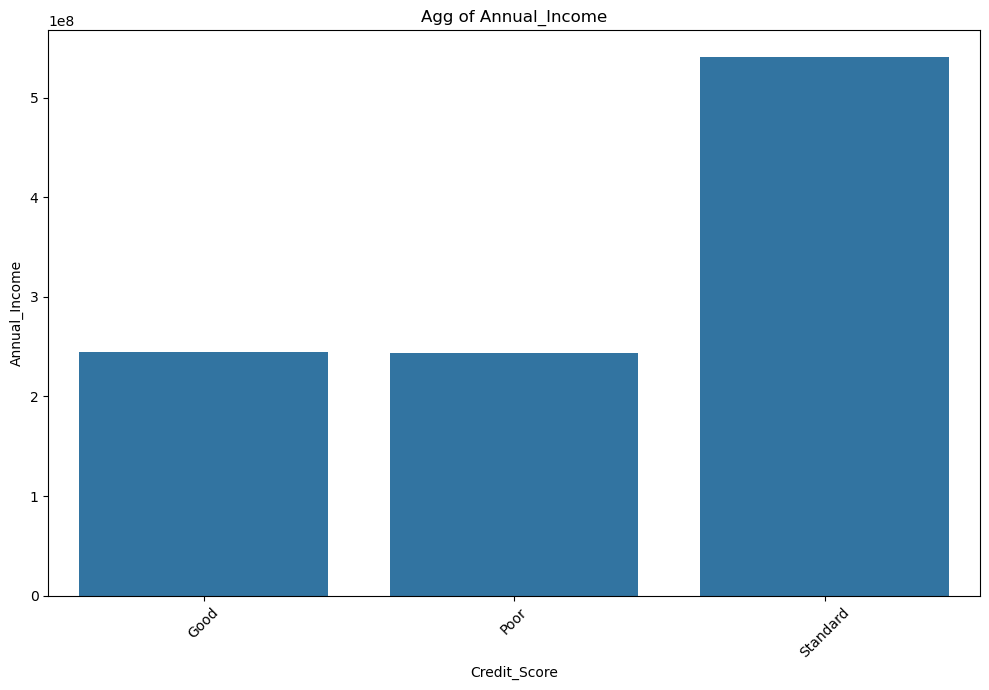

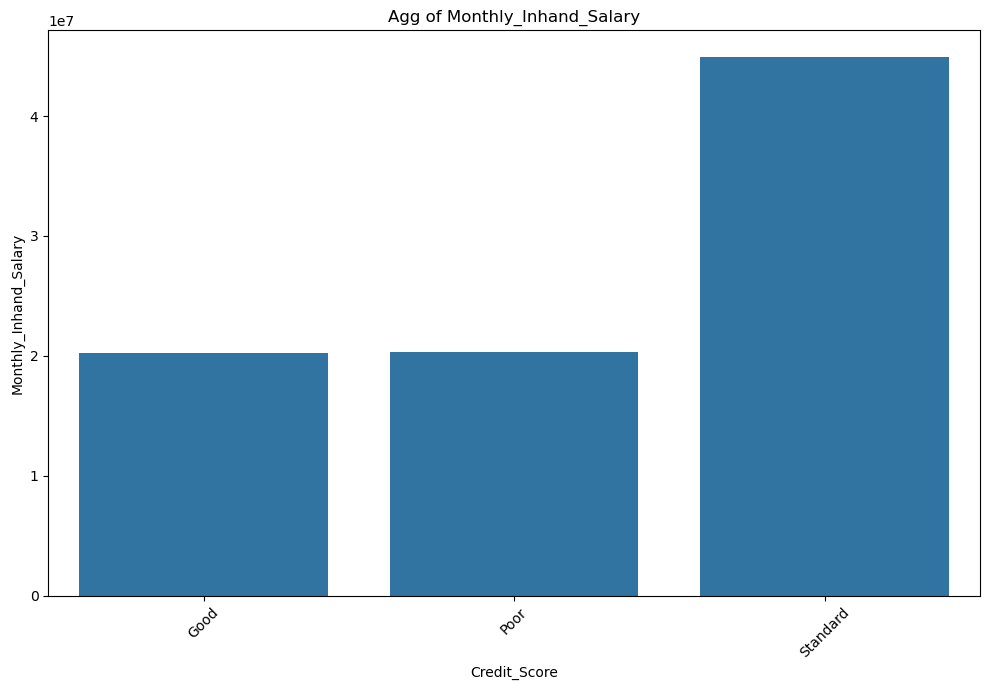

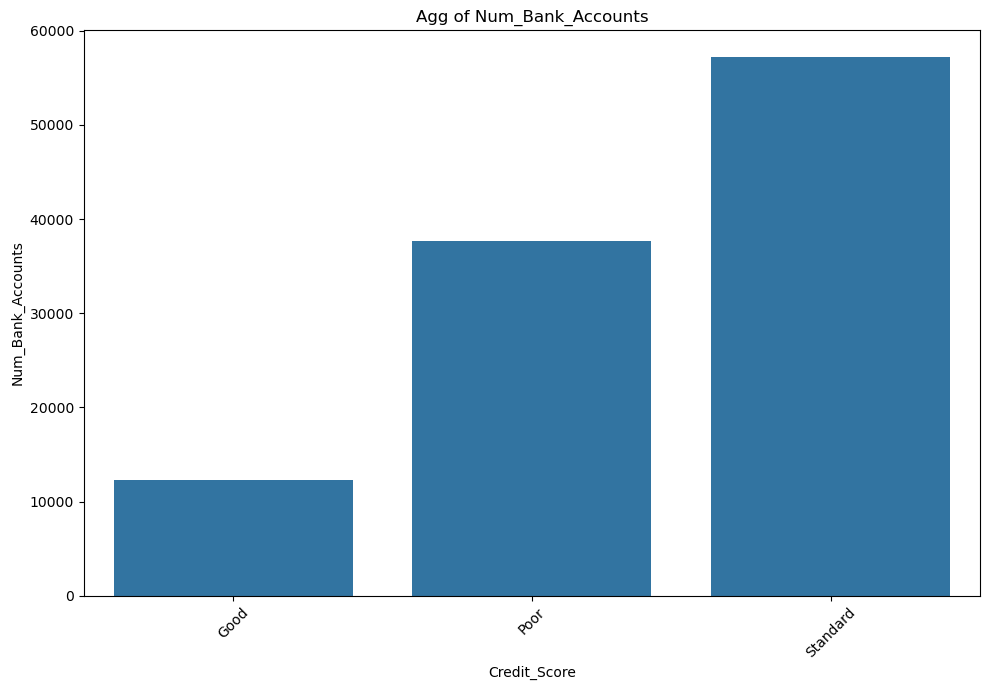

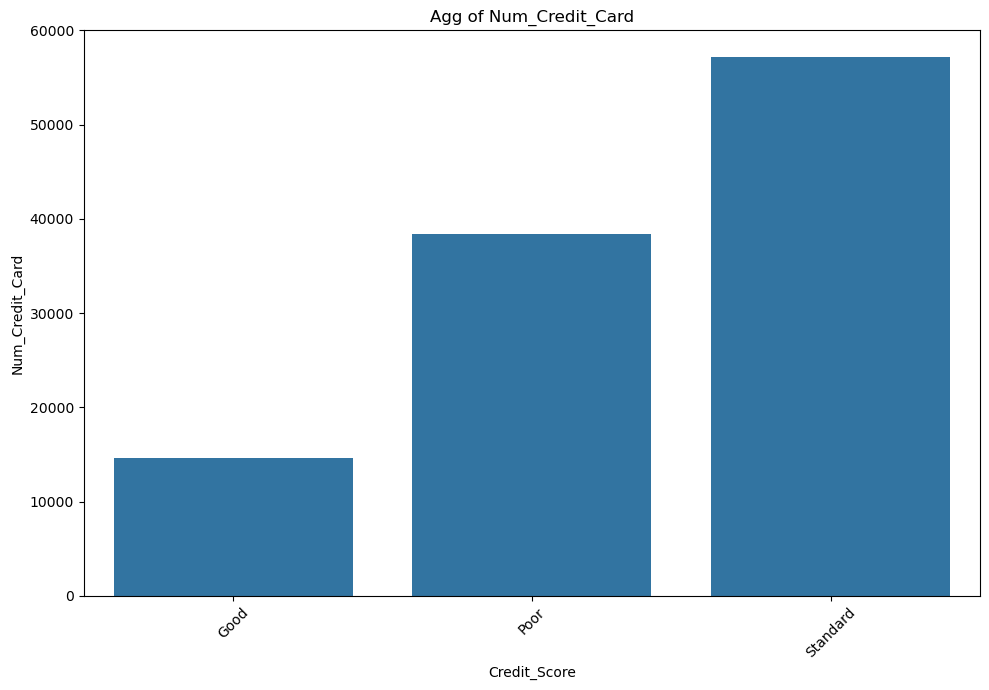

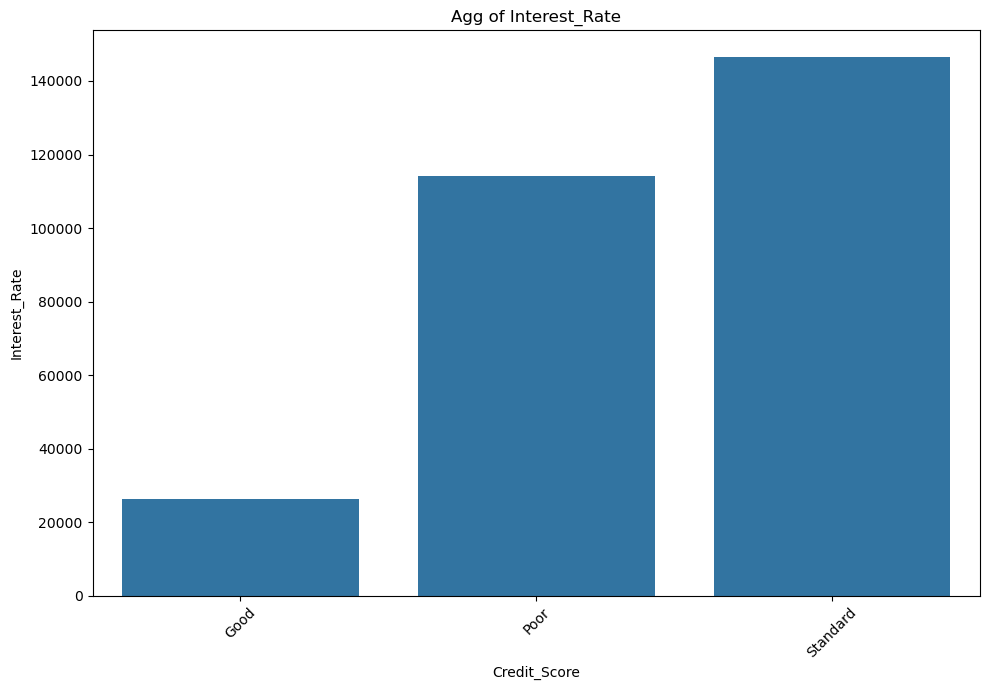

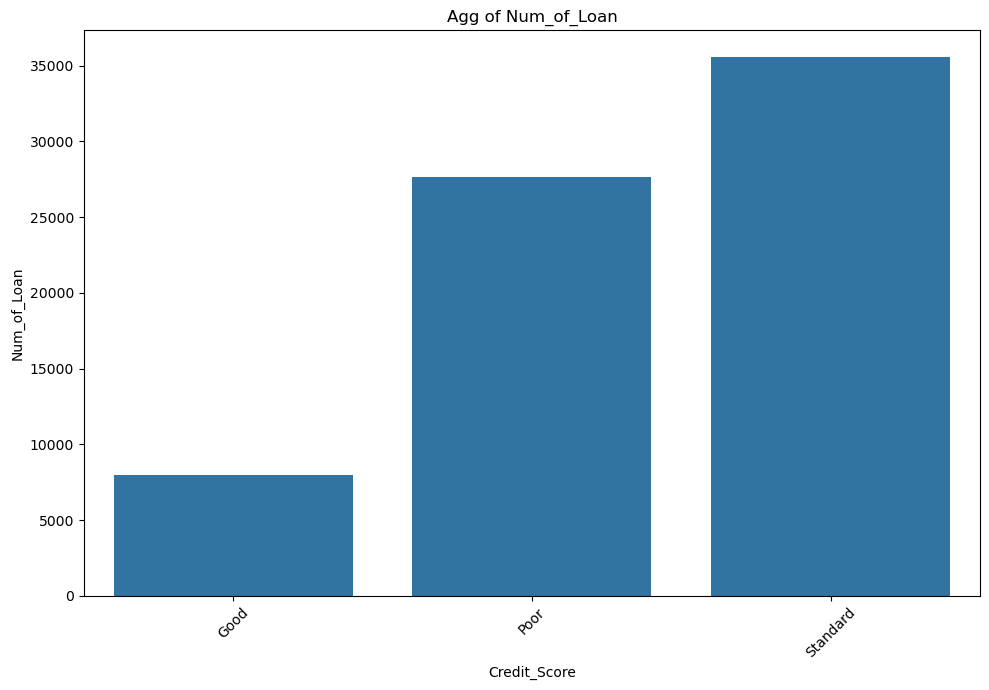

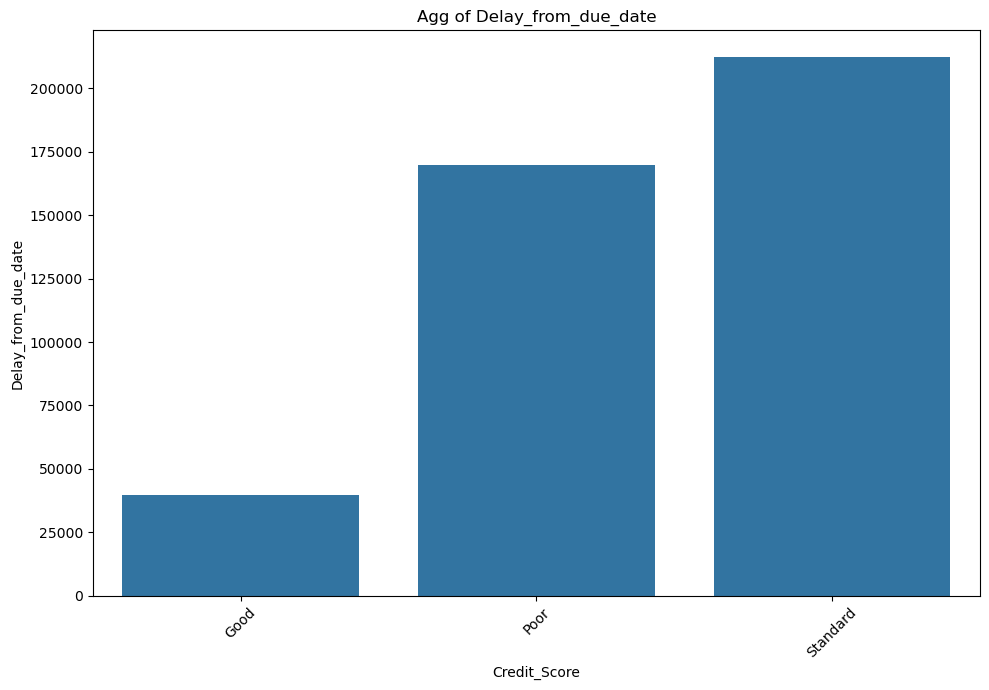

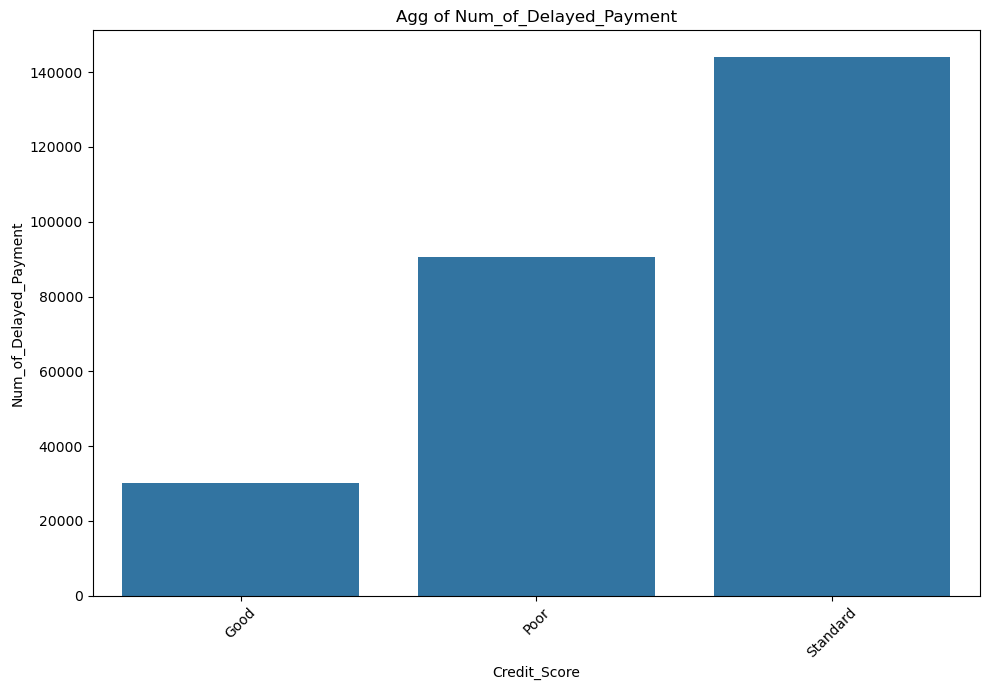

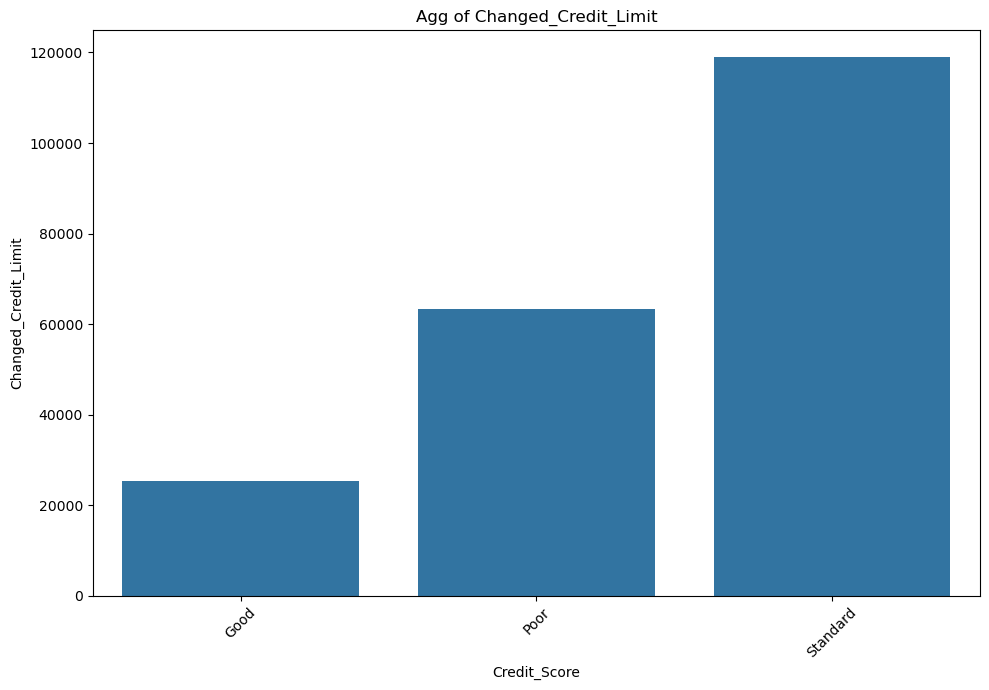

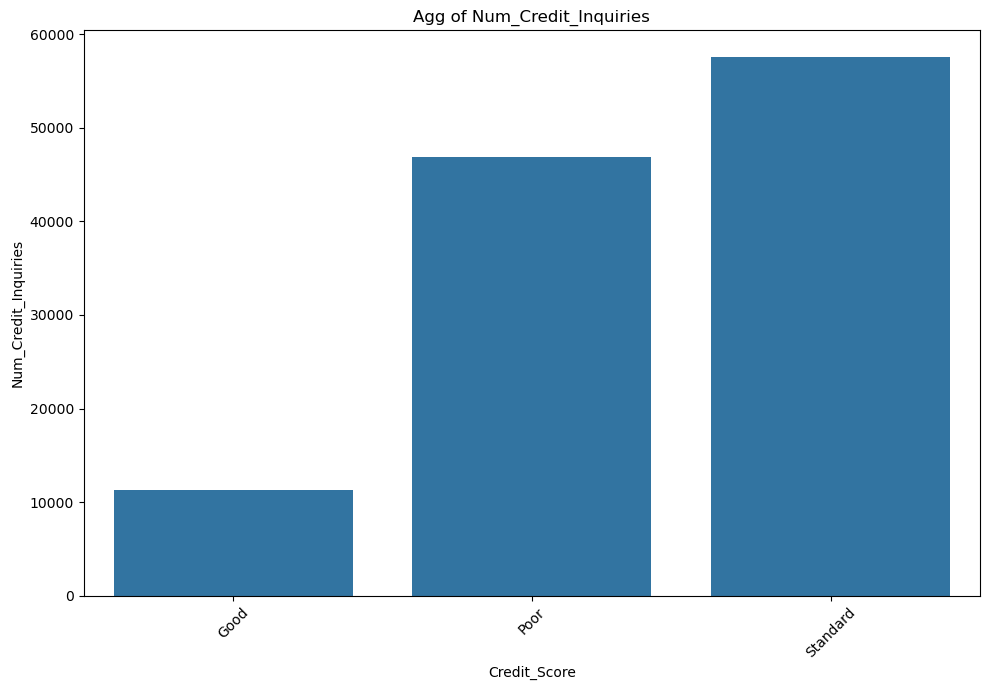

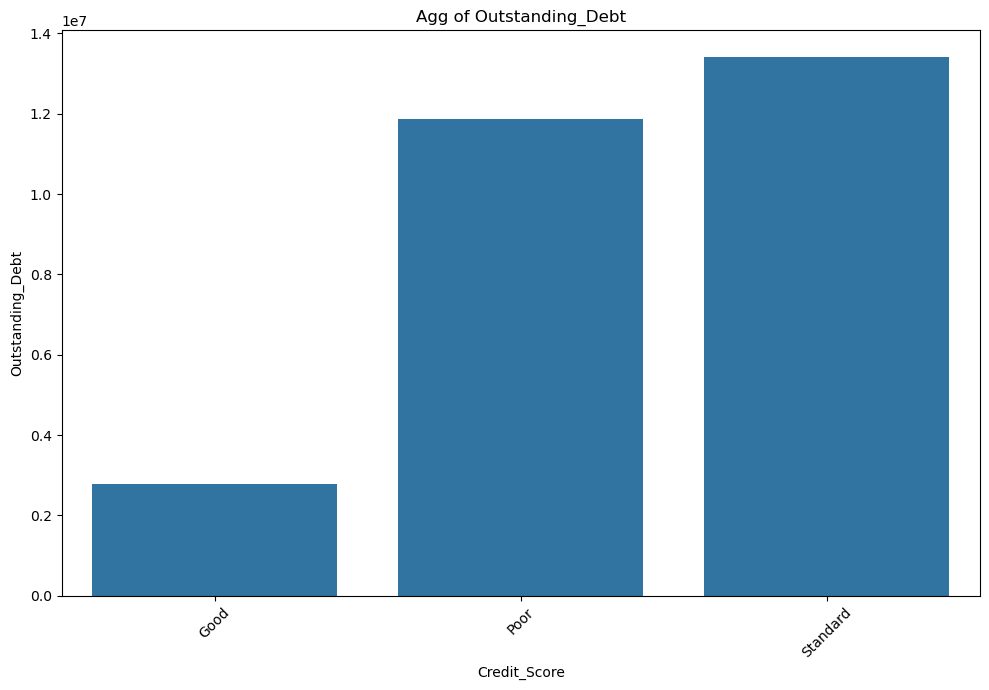

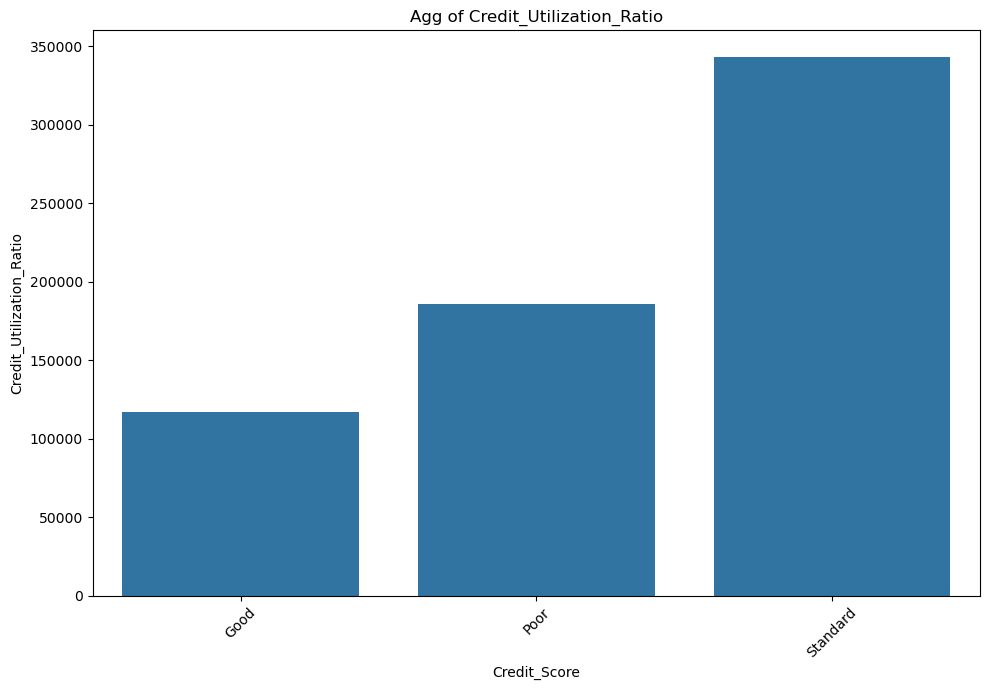

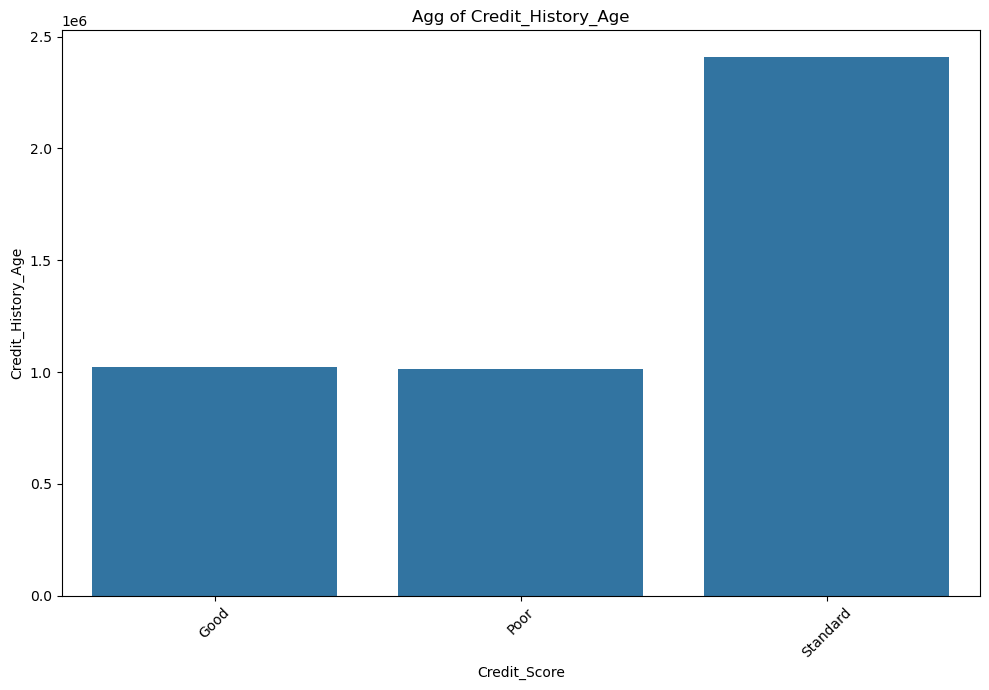

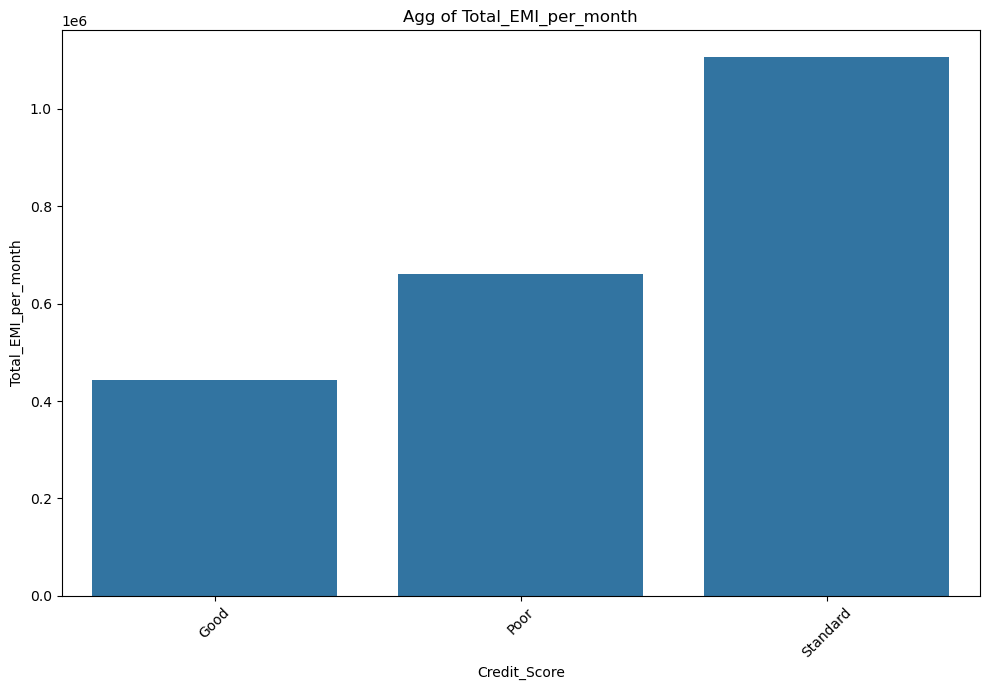

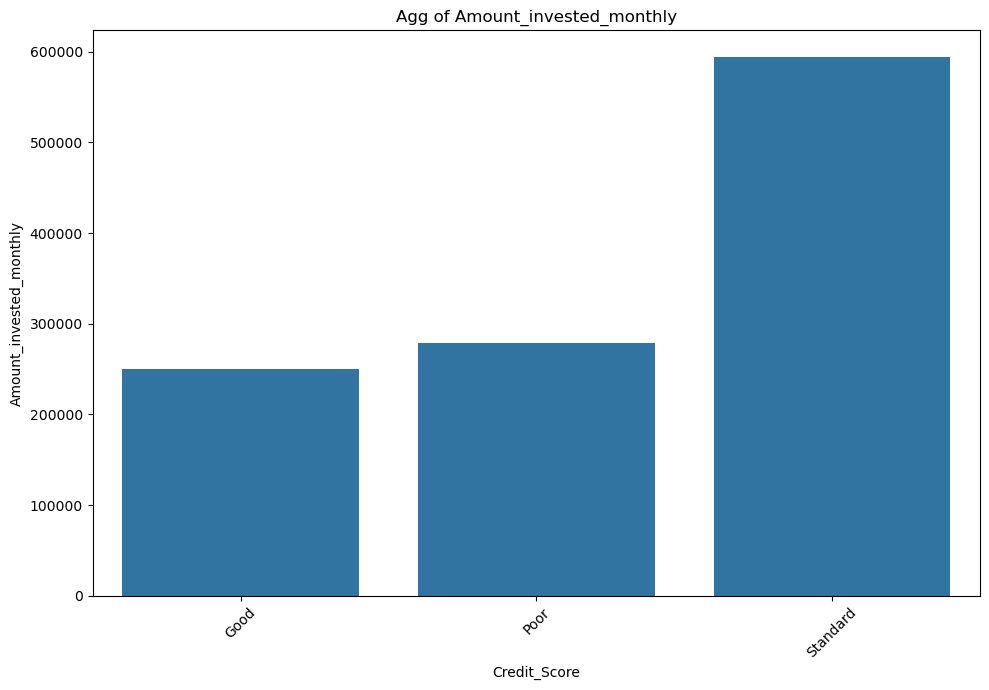

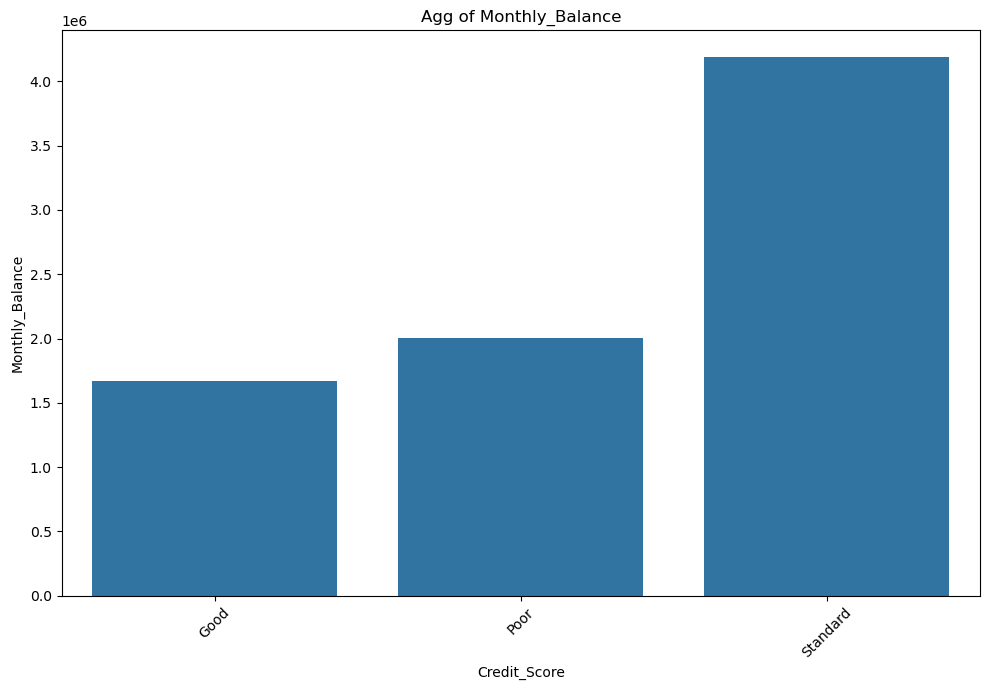

In [20]:
for col in numeric_cols.columns:
  aggregate_dataset(df, "Credit_Score", col, "sum")

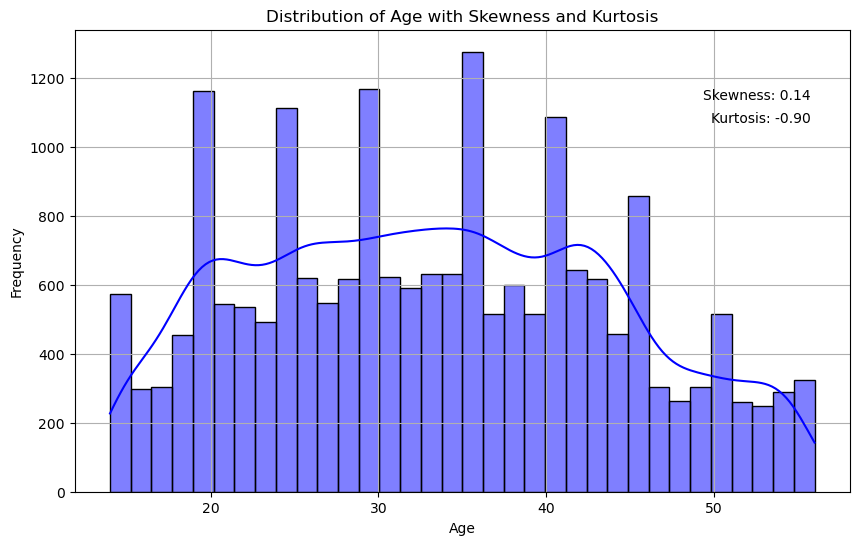

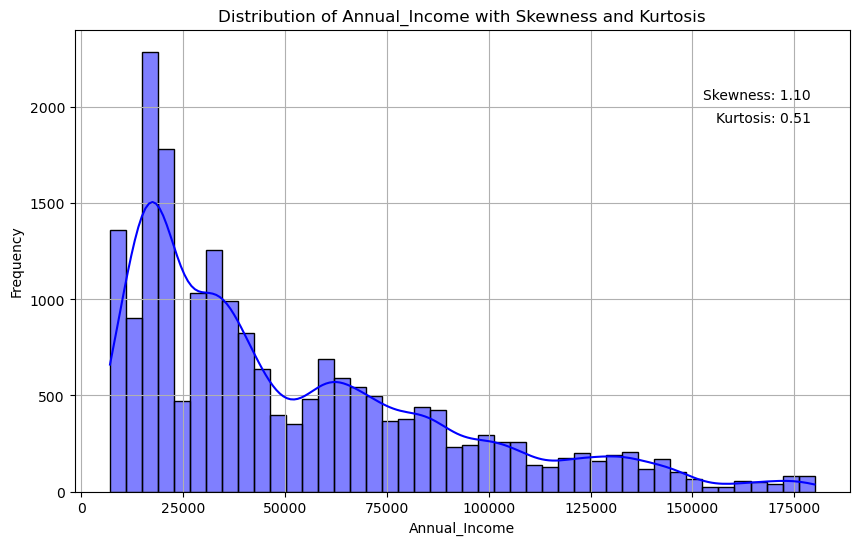

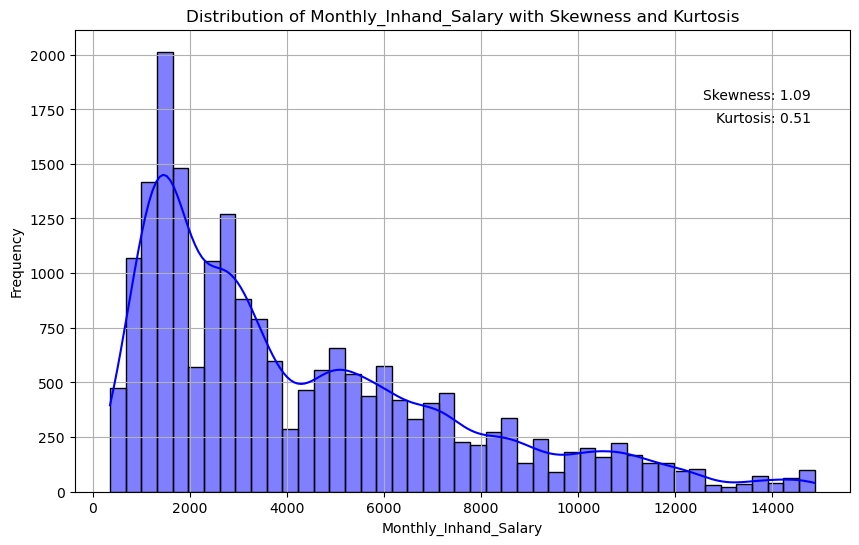

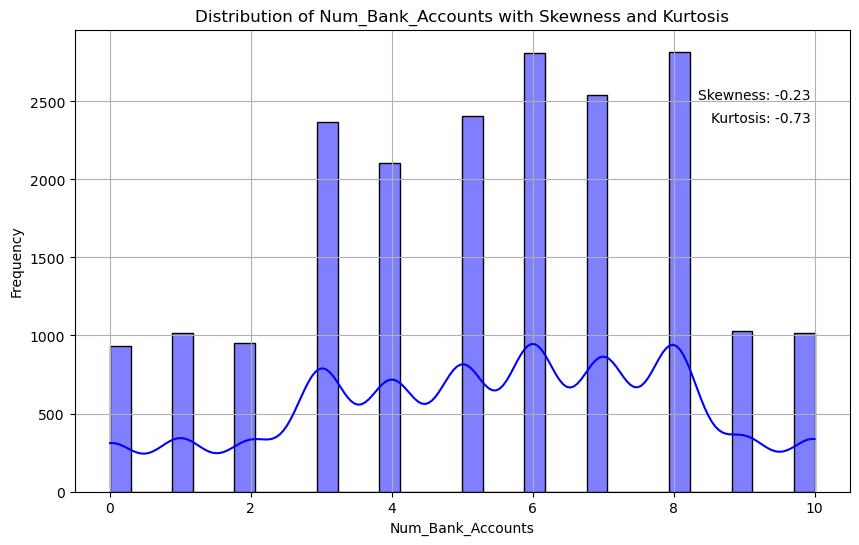

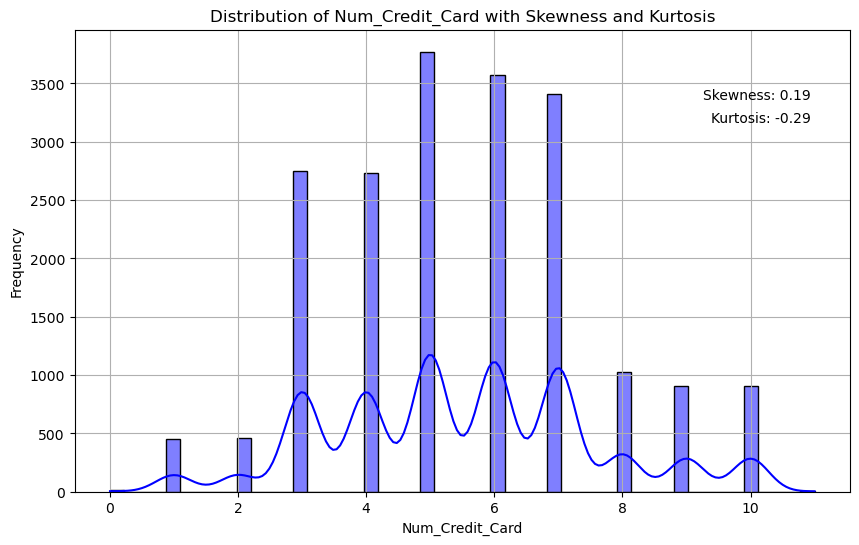

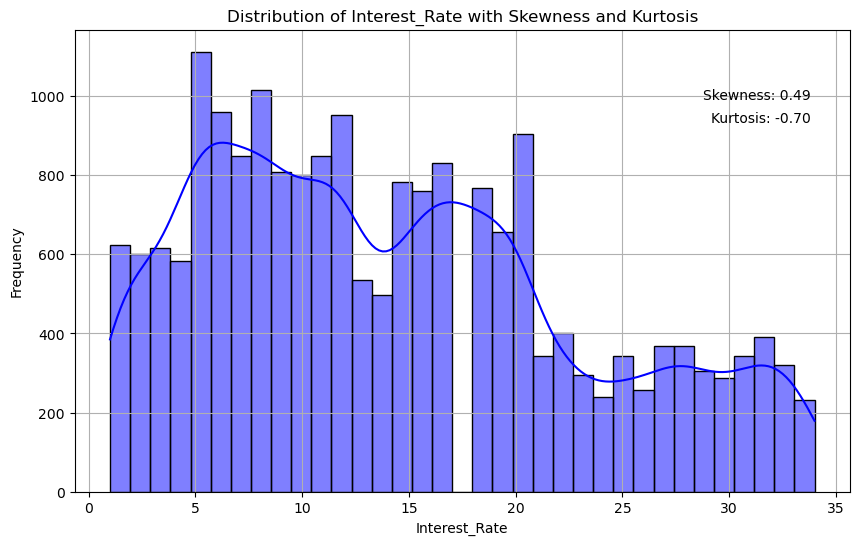

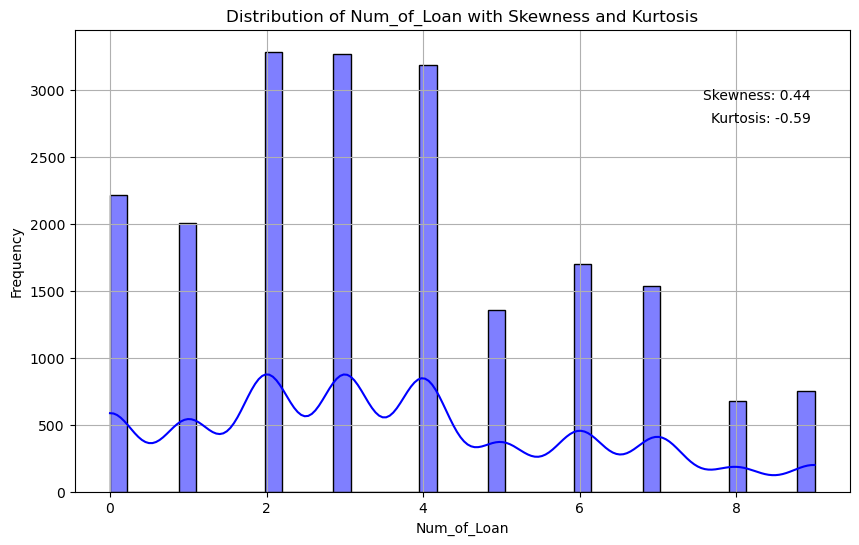

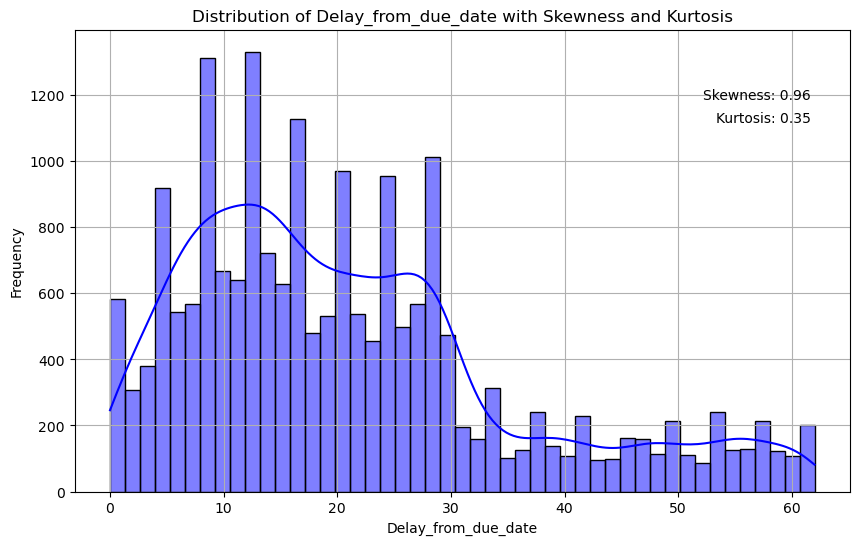

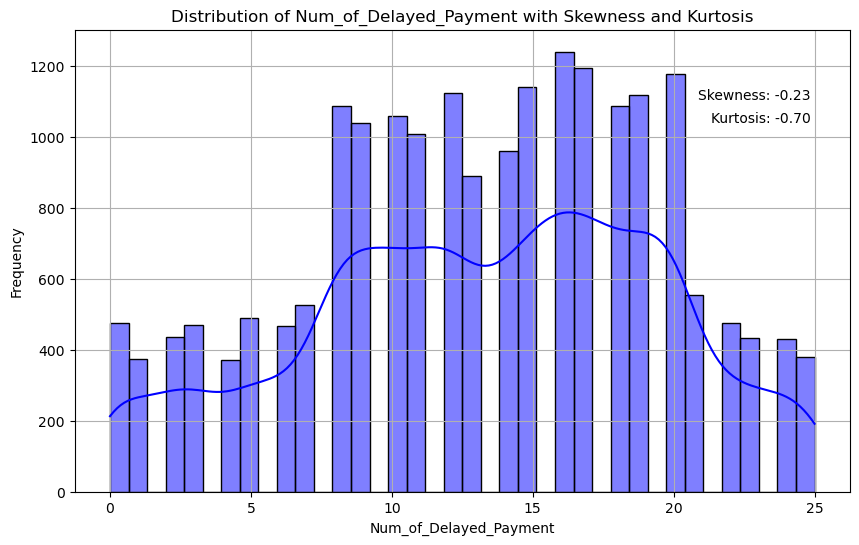

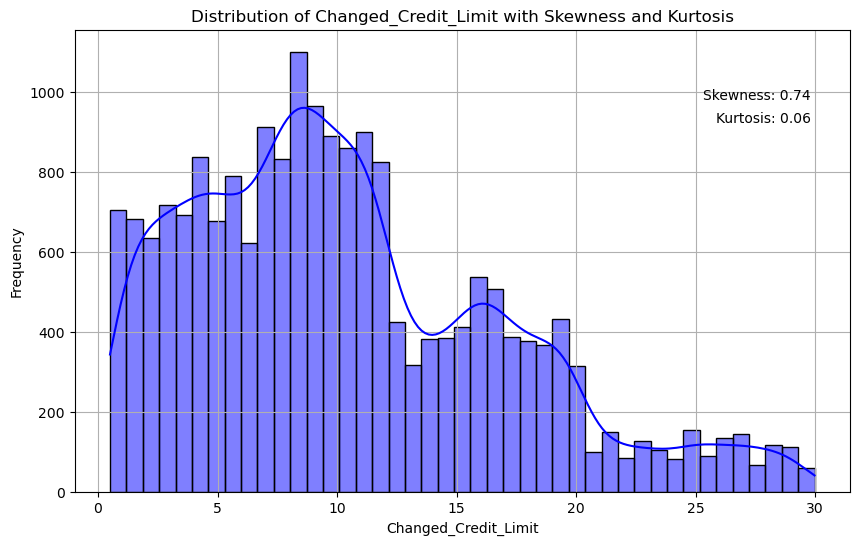

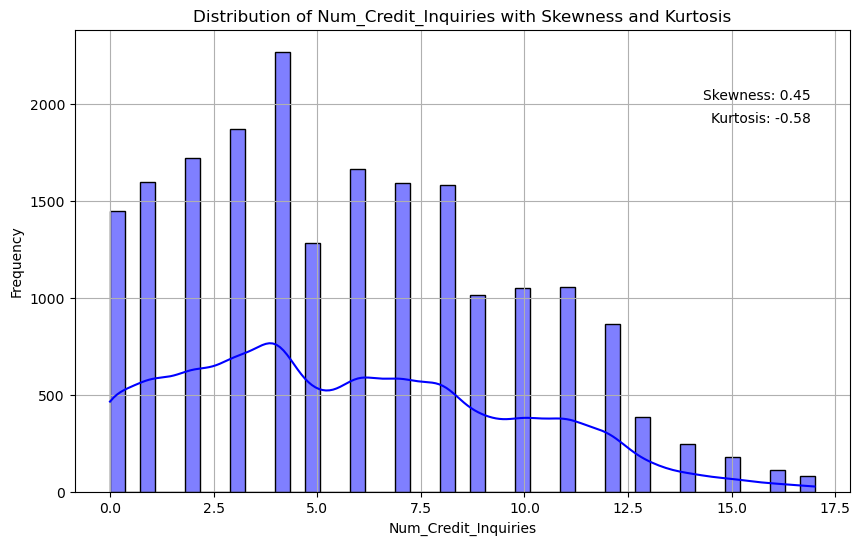

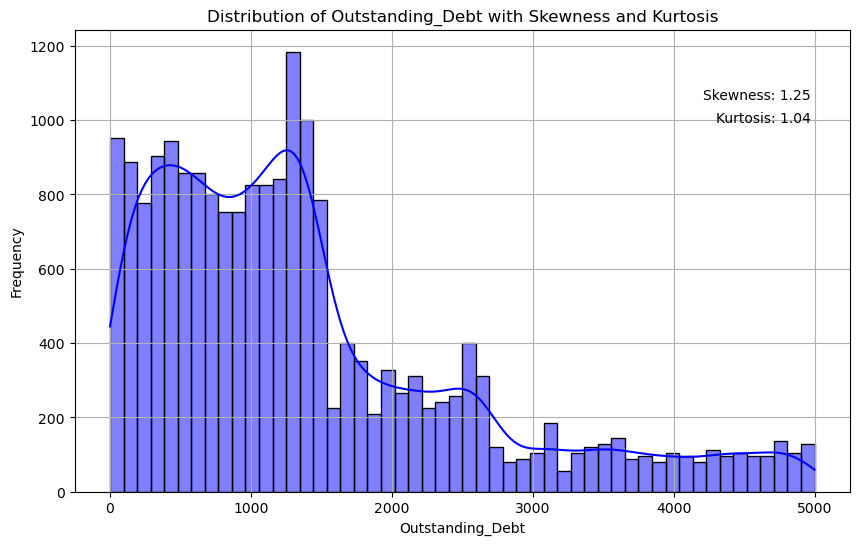

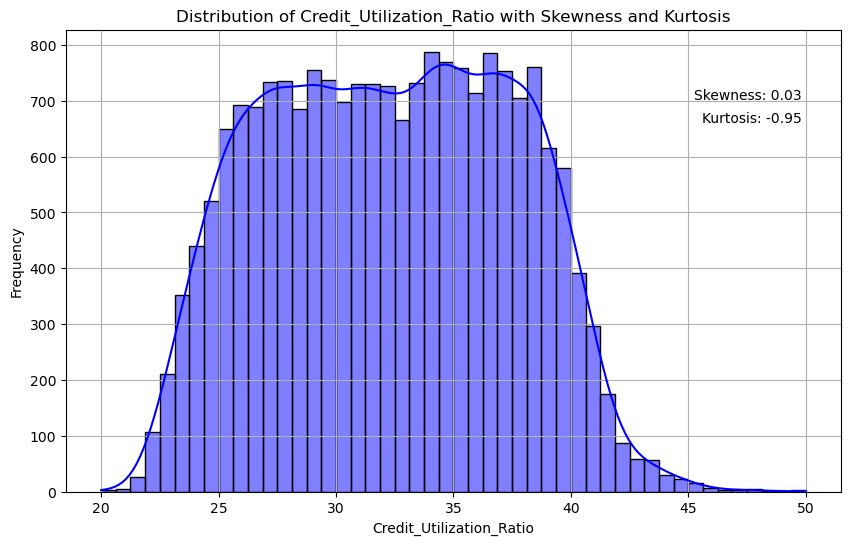

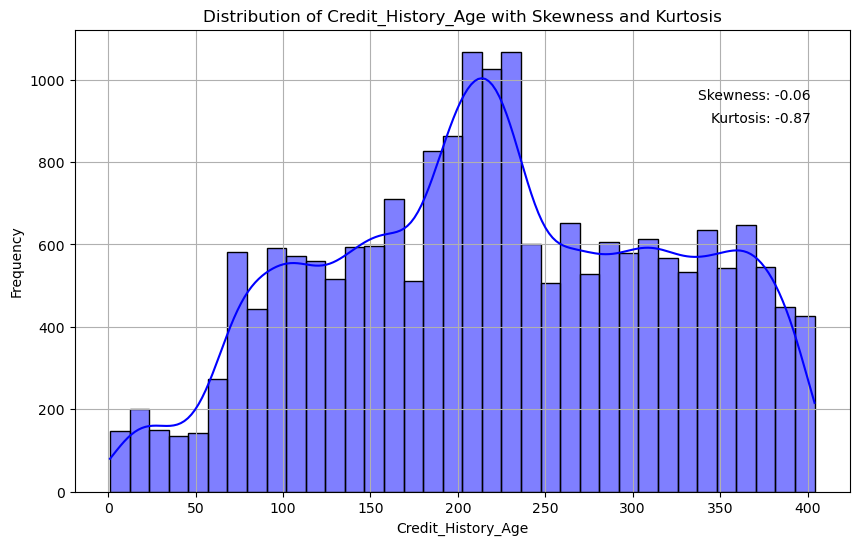

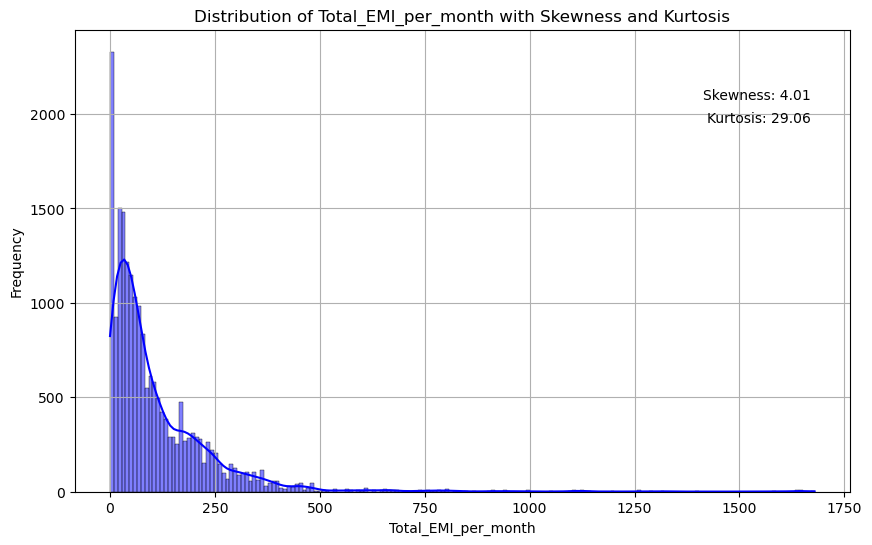

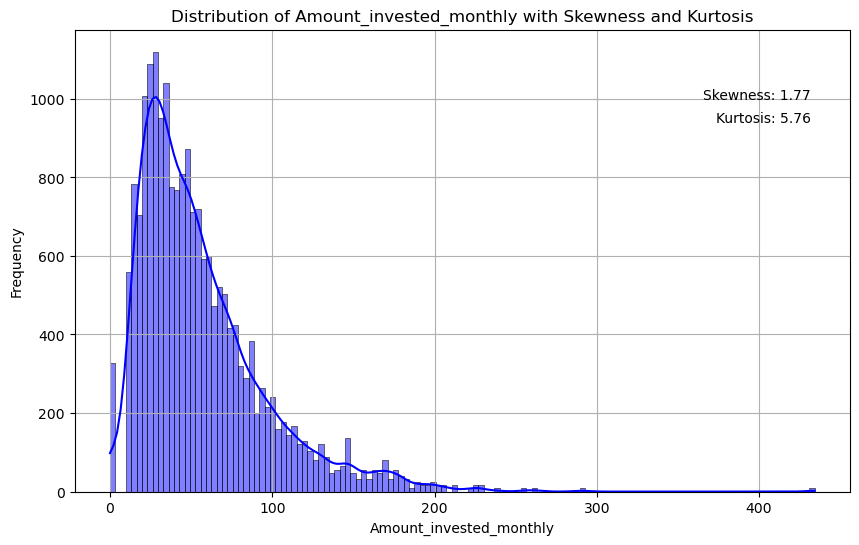

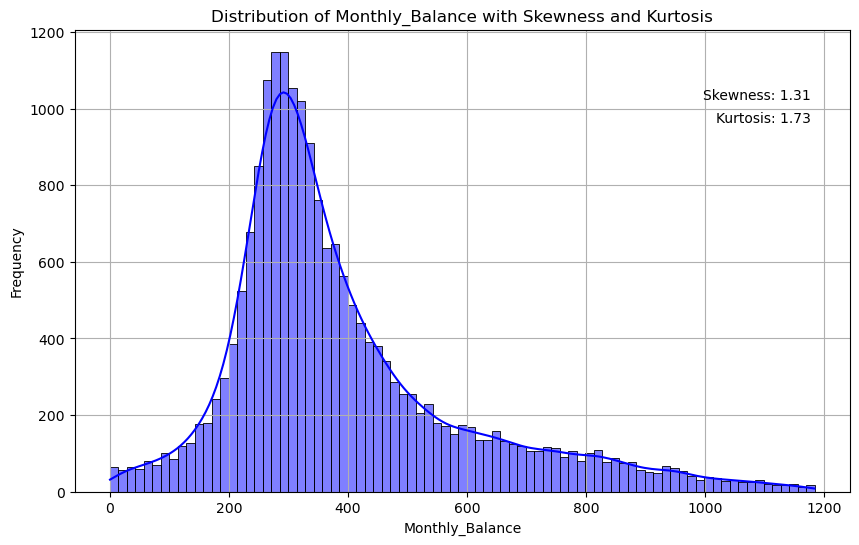

In [21]:
for col in numeric_cols.columns:
  dist_plot(df, col)

# Separate X and y variables

In [22]:
X, y = df.drop("Credit_Score", axis=1), df["Credit_Score"]

In [23]:
encoder = LabelEncoder()

y_encoded = encoder.fit_transform(y)

# Metrics to Score

In [24]:
acc_metric = make_scorer(accuracy_score, greater_is_better=True)
f1_metric = make_scorer(f1_score, greater_is_better=True, average="weighted")
precision_metric = make_scorer(precision_score, greater_is_better=True, average='weighted')
recall_metric = make_scorer(recall_score, greater_is_better=True, average='weighted')

# Create Preprocessor

In [25]:
preprocessor = create_column_transformer(cat_cols.columns, numeric_cols.columns)
preprocessor

ColumnTransformer(transformers=[('cat',
                                 Pipeline(steps=[('encoder', OneHotEncoder())]),
                                 Index(['Occupation', 'Credit_Mix', 'Payment_of_Min_Amount',
       'Payment_Behaviour'],
      dtype='object')),
                                ('numeric',
                                 Pipeline(steps=[('scaler', MinMaxScaler()),
                                                 ('PowerTransformer',
                                                  PowerTransformer())]),
                                 Index(['Age', 'Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts',
       'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan',
       'Delay_from_due_date', 'Num_of_Delayed_Payment', 'Changed_Credit_Limit',
       'Num_Credit_Inquiries', 'Outstanding_Debt', 'Credit_Utilization_Ratio',
       'Credit_History_Age', 'Total_EMI_per_month', 'Amount_invested_monthly',
       'Monthly_Balance'],
      dtype='object'))])

# PCA Analysis

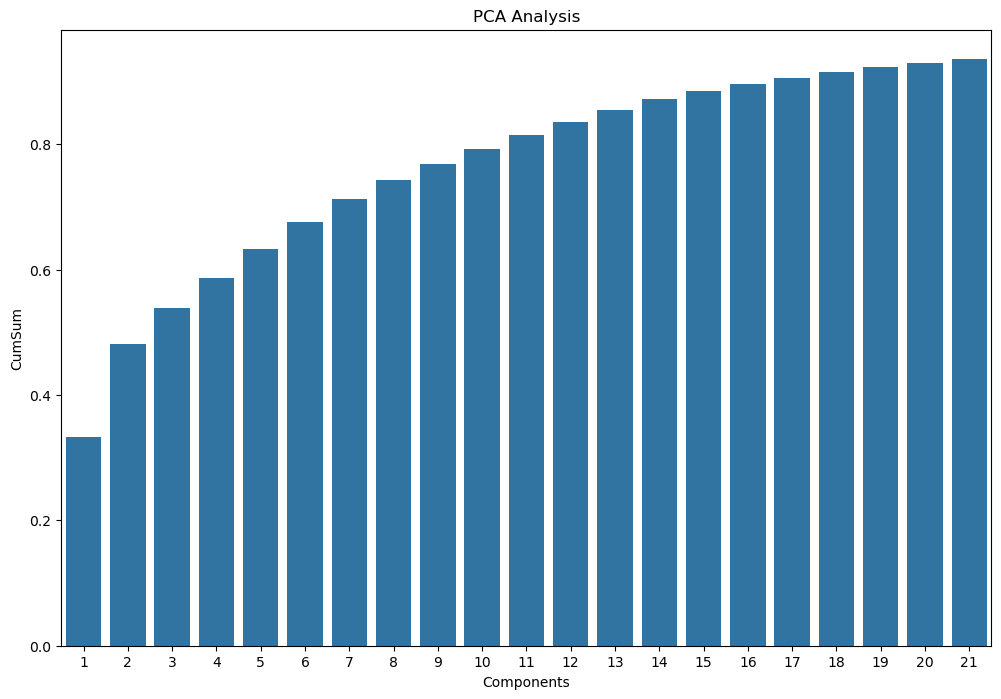

    Component    CumSum
0           1  0.333400
1           2  0.480984
2           3  0.539201
3           4  0.586700
4           5  0.633180
5           6  0.676336
6           7  0.712137
7           8  0.742590
8           9  0.768635
9          10  0.793075
10         11  0.814502
11         12  0.835080
12         13  0.854528
13         14  0.872295
14         15  0.884672
15         16  0.896002
16         17  0.906043
17         18  0.914877
18         19  0.922933
19         20  0.929539
20         21  0.935858


In [26]:
pca_analysis(X, preprocessor)

# Variance Stalls around 14-21 columns

# Test Baseline Model

In [27]:
model_name = ["DUMMY"]
models = grab_selected_models(model_name)
test_selected_models(preprocessor,model_name, models, X, y_encoded, acc_metric)

   Model   Mean  Var    STD  Test-Acc  recall-Score  precision-Score  F1-Score
0  DUMMY  0.334  0.0  0.011     0.336         0.335            0.334     0.319


# Test K Best Columns

In [28]:
model_name = ["LR"]
models = grab_selected_models(model_name)[0]
metric = mutual_info_classif
test_kbest_columns(preprocessor, X, y_encoded, models, model_name[0], metric)

/Users/maukanmir/miniforge3/envs/machine-learning-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model   K  acc_metric  f1_metric    recall  precision
0     LR   1    0.556515   0.375860  0.408756   0.370915
1     LR   2    0.558485   0.386228  0.414467   0.517190
2     LR   3    0.558939   0.386006  0.414644   0.526782
3     LR   4    0.557121   0.384068  0.412106   0.570759
4     LR   5    0.559394   0.399669  0.420148   0.527820
5     LR   6    0.573182   0.460519  0.458188   0.527836
6     LR   7    0.604697   0.527771  0.512222   0.581318
7     LR   8    0.635152   0.616939  0.648411   0.611077
8     LR   9    0.636212   0.616090  0.629009   0.610002
9     LR  10    0.640758   0.624017  0.652909   0.617402
10    LR  11    0.643485   0.624854  0.636801   0.619531
11    LR  12    0.645606   0.627333  0.637541   0.622626
12    LR  13    0.645909   0.627777  0.638296   0.622620
13    LR  14    0.649394   0.629793  0.639984   0.625742
14    LR  15    0.651515   0.632671  0.642761   0.627652
15    LR  16    0.649545   0.629041  0.638375   0.625825
16    LR  17    0.651061   0.631191  0.640343   0.628062
17    LR  18    0.653939   0.634479  0.644421   0.630351
18    LR  19    0.653485   0.633228  0.642104   0.629825
19    LR  20    0.653485   0.633017  0.641743   0.629721
20    LR  21    0.653182   0.632684  0.641147   0.629523

In [29]:
metric = f_classif
test_kbest_columns(preprocessor, X, y_encoded, models, model_name[0], metric)

/Users/maukanmir/miniforge3/envs/machine-learning-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model   K  acc_metric  f1_metric    recall  precision
0     LR   1    0.579545   0.441052  0.552523   0.370056
1     LR   2    0.621515   0.593450  0.635581   0.602734
2     LR   3    0.636364   0.616735  0.652987   0.615458
3     LR   4    0.636212   0.619208  0.655508   0.614287
4     LR   5    0.635909   0.619156  0.655350   0.613856
5     LR   6    0.632727   0.618641  0.656514   0.610894
6     LR   7    0.633636   0.617207  0.634653   0.609510
7     LR   8    0.633333   0.617044  0.634432   0.609341
8     LR   9    0.633182   0.616221  0.634085   0.608782
9     LR  10    0.643636   0.627186  0.643300   0.619710
10    LR  11    0.643182   0.626689  0.642779   0.619264
11    LR  12    0.643182   0.627417  0.644092   0.619782
12    LR  13    0.642727   0.625865  0.640056   0.619206
13    LR  14    0.642424   0.625687  0.640303   0.618969
14    LR  15    0.651061   0.632333  0.643438   0.627871
15    LR  16    0.653333   0.633880  0.644491   0.629594
16    LR  17    0.654091   0.634834  0.645093   0.630673
17    LR  18    0.653030   0.633378  0.643223   0.629613
18    LR  19    0.653485   0.634182  0.644228   0.630119
19    LR  20    0.653939   0.634072  0.643389   0.630401
20    LR  21    0.659242   0.639668  0.648739   0.636048

# 8 Columns gives most of the performance

In [31]:
kbest = SelectKBest(score_func=f_classif, k=8)
model_names = ["SVC", "LR", "KNN"]
models = grab_selected_models(model_names)
test_selected_models(preprocessor,model_names, models, X, y_encoded, acc_metric, kbest)

/Users/maukanmir/miniforge3/envs/machine-learning-env/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/Users/maukanmir/miniforge3/envs/machine-learning-env/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


  Model   Mean  Var    STD  Test-Acc  recall-Score  precision-Score  F1-Score
2   KNN  0.752  0.0  0.009     0.597         0.568            0.563     0.565
0   SVC  0.685  0.0  0.009     0.677         0.691            0.652     0.663
1    LR  0.633  0.0  0.011     0.630         0.634            0.606     0.613


In [32]:
kbest = SelectKBest(score_func=f_classif, k=8)
model_names = ["RFC", "XGB", "GBC"]
models = grab_selected_models(model_names)
test_selected_models(preprocessor,model_names, models, X, y_encoded, acc_metric, kbest)

/Users/maukanmir/miniforge3/envs/machine-learning-env/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/Users/maukanmir/miniforge3/envs/machine-learning-env/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/Users/maukanmir/miniforge3/envs/machine-learning-env/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/Users/maukanmir/miniforge3/envs/machine-learning-env/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: U

  Model   Mean  Var    STD  Test-Acc  recall-Score  precision-Score  F1-Score
1   XGB  0.794  0.0  0.010     0.633         0.595            0.601     0.598
0   RFC  0.785  0.0  0.009     0.626         0.595            0.595     0.595
2   GBC  0.712  0.0  0.009     0.667         0.658            0.639     0.646


# Hyper Parameter Tuning

In [33]:
params = {
    'GBC': {
        'model__n_estimators': [100, 200, 300],
        'model__learning_rate': [0.01, 0.1, 0.2],
        'model__max_depth': [3, 4, 5],
        'model__min_samples_split': [2, 4],
        'model__min_samples_leaf': [1, 2]
    },
    'XGB': {
        'model__n_estimators': [100, 150, 200],
        'model__learning_rate': [0.01, 0.05, 0.1],
        'model__max_depth': [3, 5, 7],
        'model__subsample': [0.6, 0.8, 1.0],
        'model__colsample_bytree': [0.6, 0.8, 1.0]
    },
    'RFC': {
        'model__n_estimators': [100, 200, 300],
        'model__max_depth': [None, 10, 20],
        'model__min_samples_split': [2, 5, 10],
        'model__min_samples_leaf': [1, 2, 4]
    },
    'LR': {
        'model__C': [0.01, 0.1, 1, 10],
        'model__penalty': ['l1', 'l2'],
        'model__solver': ['liblinear', 'saga']
    },
    'SVC': {
        'model__C': [0.1, 1, 10],
        'model__kernel': ['linear', 'rbf'],
        'model__gamma': ['scale', 'auto'],
        'model__degree': [2, 3, 4]
    }
}

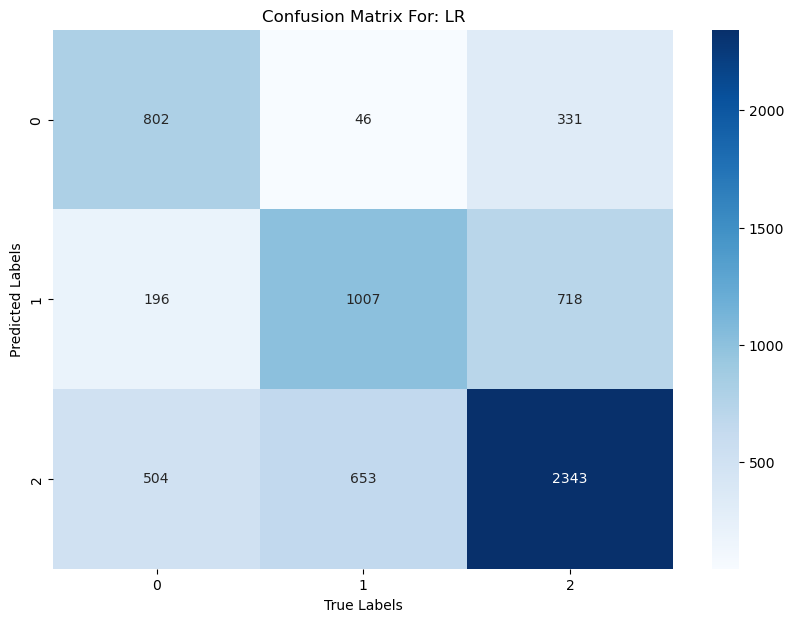

The Best Param: {'model__solver': 'liblinear', 'model__penalty': 'l2', 'model__C': 0.01}


/Users/maukanmir/miniforge3/envs/machine-learning-env/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


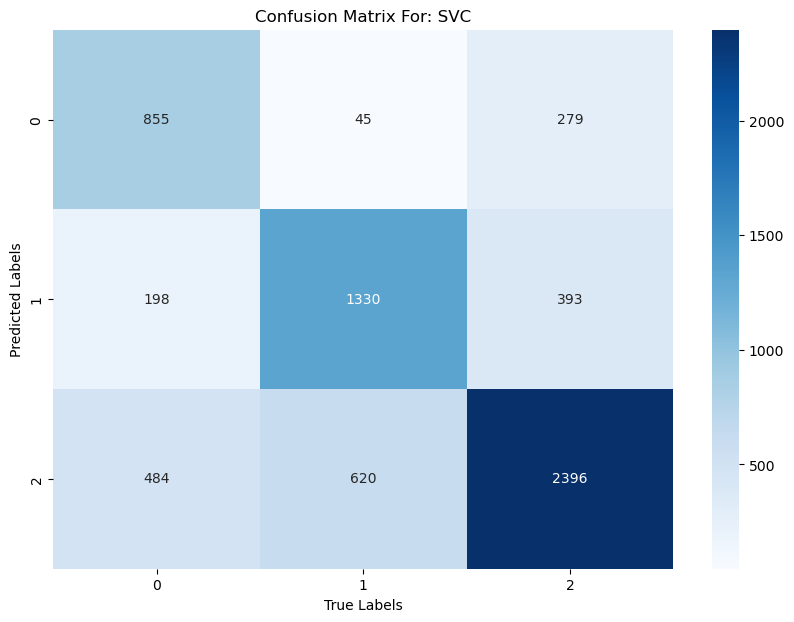

The Best Param: {'model__kernel': 'rbf', 'model__gamma': 'scale', 'model__degree': 3, 'model__C': 10}
  Model  Test-Acc  F1-Score  recall-Score  precision-Score
1   SVC  0.694091  0.679488      0.700703         0.667970
0    LR  0.629091  0.611161      0.624624         0.604989


In [35]:
model_names = ["LR", "SVC"]
models = grab_selected_models(model_names)
performance_df = optimization_search(preprocessor, model_names, models, X, y_encoded, RandomizedSearchCV, params, acc_metric, kbest)
print(performance_df.sort_values(by="Test-Acc", ascending=False))

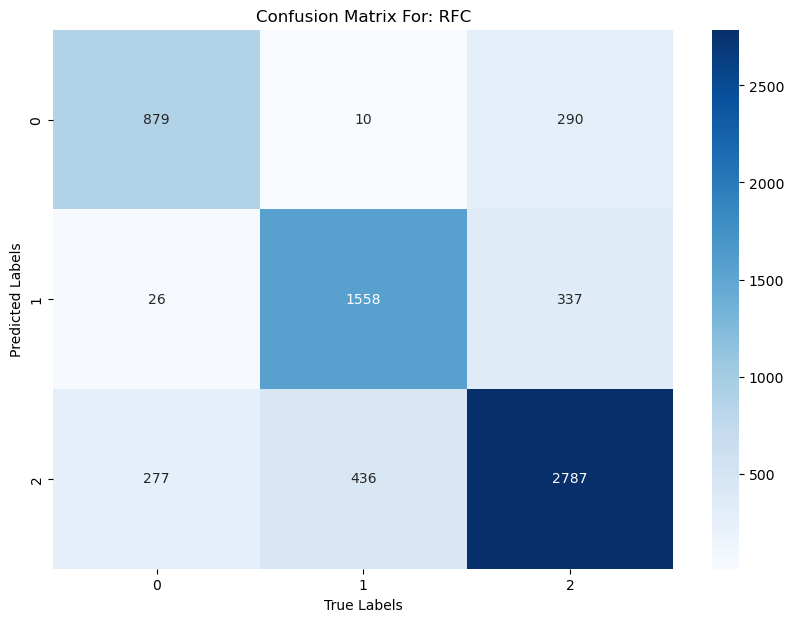

The Best Param: {'model__n_estimators': 200, 'model__min_samples_split': 5, 'model__min_samples_leaf': 2, 'model__max_depth': None}


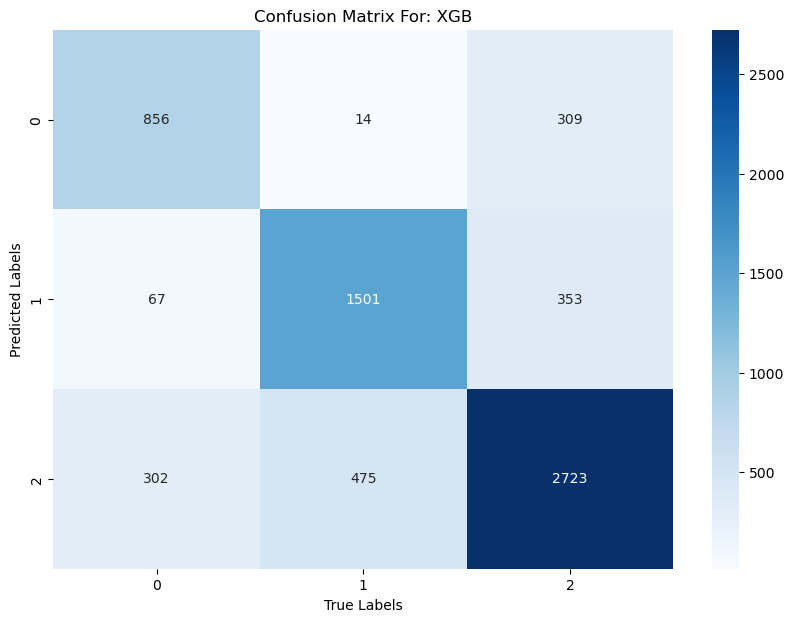

The Best Param: {'model__subsample': 0.8, 'model__n_estimators': 200, 'model__max_depth': 7, 'model__learning_rate': 0.05, 'model__colsample_bytree': 1.0}


In [36]:
model_names = ["RFC", "XGB", "GBC"]
models = grab_selected_models(model_names)
performance_df = optimization_search(preprocessor, model_names, models, X, y_encoded, RandomizedSearchCV, params, acc_metric, kbest)
print(performance_df.sort_values(by="Test-Acc", ascending=False))